# The order in which the model was created
# 1. BiLSTM
# 2. PCA-STACKED-LSTM
# 3. REGULAR STACKED-LSTM
# 4. SINGLE-LAYERED-LSTM
# 5. GRU
# 6. VOTING REGRESSOR

# 1. Data and Library Loading

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shap
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
import shap
tf.compat.v1.disable_v2_behavior()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

from itertools import cycle

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
df = yf.download('^GSPC', start='2012-01-01', end='2022-12-31')
#df = pd.read_csv("/Users/parkjs9416/Documents/Dissertation/Dissertation_project_code_and_data/Dataset/sp500_10year_data.csv")
# df

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df1 = yf.download('^GSPC', start='2012-01-01', end='2022-12-31')
# df1

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df1.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', name='Date', length=2768, freq=None)

In [ ]:
# #Making the percentage changes in each day
# df1['Pct_change'] = df1['Close'].pct_change()
# # data['Pct_change'] = np.log(1+data['Pct_change'])
# df1['Pct_change'] = np.log1p(df1['Pct_change'])
# # Choose the desired time periods for the moving averages
# short_period = 12  # Short-term EMA period
# long_period = 26  # Long-term EMA period
# signal_period = 9  # Signal line EMA period

# # Calculate the short-term EMA
# df1['Short EMA'] = df1['Close'].ewm(span=short_period, adjust=False).mean()

# # Calculate the long-term EMA
# df1['Long EMA'] = df1['Close'].ewm(span=long_period, adjust=False).mean()

# # Calculate the MACD line
# df1['MACD'] = df1['Short EMA'] - df1['Long EMA']

# # Calculate the signal line
# df1['Signal Line'] = df1['MACD'].ewm(span=signal_period, adjust=False).mean()

# # Calculate the MACD histogra
# df1['MACD Histogram'] = df1['MACD'] - df1['Signal Line']
# # Choose the desired time period for the moving average and standard deviation
# window = 20  # Number of Trading days in a month
# num_std = 2
# # 2 standard deviations above and below the middle band provides
# #a range that encompasses a large portion of typical price movements

# # Calculate the logarithmic returns
# df1['Log Returns'] = np.log(df1['Close'] / df1['Close'].shift(1))

# # Calculate the volatility
# df1['Volatility'] = df1['Log Returns'].rolling(window=20).std() * np.sqrt(252)

# # Calculate the middle band (simple moving average)
# df1['Middle Band'] = df1['Close'].rolling(window=window).mean()

# # Calculate the standard deviation of the closing prices
# df1['Std Dev'] = df1['Close'].rolling(window=window).std()

# # Calculate the upper band and lower band
# df1['Upper Band'] = df1['Middle Band'] + (num_std * df1['Std Dev'])
# df1['Lower Band'] = df1['Middle Band'] - (num_std * df1['Std Dev'])

# #Making Next day's close price column in each date.
# df1['Next_day'] = df1['Close'].shift(-1)


# # Display the updated DataFrame with the Bollinger Bands columns
# df1 = df1.dropna()

# 2. Feature Engineering

In [ ]:
#Making the percentage changes in each day
df['Pct_change'] = df['Close'].pct_change()
# data['Pct_change'] = np.log(1+data['Pct_change'])
df['Pct_change'] = np.log1p(df['Pct_change'])
# Choose the desired time periods for the moving averages
short_period = 12  # Short-term EMA period
long_period = 26  # Long-term EMA period
signal_period = 9  # Signal line EMA period

# Calculate the short-term EMA
df['Short EMA'] = df['Close'].ewm(span=short_period, adjust=False).mean()

# Calculate the long-term EMA
df['Long EMA'] = df['Close'].ewm(span=long_period, adjust=False).mean()

# Calculate the MACD line
df['MACD'] = df['Short EMA'] - df['Long EMA']

# Calculate the signal line
df['Signal Line'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()

# Calculate the MACD histogram
df['MACD Histogram'] = df['MACD'] - df['Signal Line']
# Choose the desired time period for the moving average and standard deviation
window = 20  # Number of Trading days in a month
num_std = 2
# 2 standard deviations above and below the middle band provides
#a range that encompasses a large portion of typical price movements

# Calculate the logarithmic returns
df['Log Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Calculate the volatility
df['Volatility'] = df['Log Returns'].rolling(window=20).std() * np.sqrt(252)

# Calculate the middle band (simple moving average)
df['Middle Band'] = df['Close'].rolling(window=window).mean()

# Calculate the standard deviation of the closing prices
df['Std Dev'] = df['Close'].rolling(window=window).std()

# Calculate the upper band and lower band
df['Upper Band'] = df['Middle Band'] + (num_std * df['Std Dev'])
df['Lower Band'] = df['Middle Band'] - (num_std * df['Std Dev'])

#Making Next day's close price column in each date.
df['Next_day'] = df['Close'].shift(-1)


# Display the updated DataFrame with the Bollinger Bands columns
# df

In [ ]:
df.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Pct_change         1
Short EMA          0
Long EMA           0
MACD               0
Signal Line        0
MACD Histogram     0
Log Returns        1
Volatility        20
Middle Band       19
Std Dev           19
Upper Band        19
Lower Band        19
Next_day           1
dtype: int64

In [ ]:
df = df.dropna()
# df

In [ ]:
df.isnull().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Pct_change        0
Short EMA         0
Long EMA          0
MACD              0
Signal Line       0
MACD Histogram    0
Log Returns       0
Volatility        0
Middle Band       0
Std Dev           0
Upper Band        0
Lower Band        0
Next_day          0
dtype: int64

In [ ]:
# df.columns

## 2.1 Checking the Correlation of each variables

In [ ]:
import seaborn as sns

In [ ]:
# plt.rcParams["figure.figsize"] = (20,20)
# sns.heatmap(df.corr(),
#            annot = True, #Vaue on the heatmap
#            cmap = 'Greens', #Colour
#            vmin = -1, vmax=1 , #Boundary of Colour chart -1 ~ +1
#           )

In [ ]:
# df1.corr()

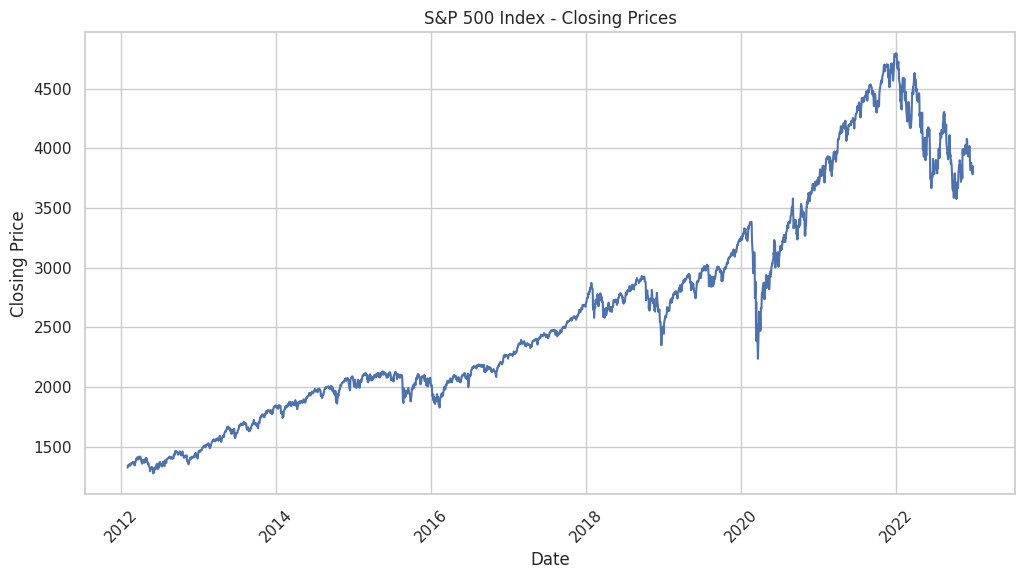

In [ ]:
# Sort the DataFrame by date in ascending order
data = df.sort_values('Next_day')

# Set the Seaborn style
sns.set(style='whitegrid')

# Create the line plot using Seaborn
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
sns.lineplot(data=data, x='Date', y='Next_day')

# Set the plot title and axis labels
plt.title('S&P 500 Index - Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
# df[['High','Low','Open','Close']].plot(figsize = (15, 5), alpha = 0.5)

In [ ]:
# df[['MACD','Signal Line']].plot(figsize = (15, 5), alpha = 0.5)

In [ ]:
# df[["Close","Short EMA", "Long EMA","Middle Band", 'Upper Band', 'Lower Band']].plot(figsize=(10,7))
# plt.legend(loc="best")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.title("Close Price trend with BollingerBand and the EMA")

In [ ]:
# # Ensure the DataFrame's index is datetime
# df.index = pd.to_datetime(df.index)

# # Filter the data for the required range
# mask = (df.index >= '2012-01-01') & (df.index <= '2012-12-31')
# filtered_df = df.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Upper Band', label='Upper Band')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Middle Band', label='Middle Band')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Lower Band', label='Lower Band')

# plt.title('S&P 500 Close Prices and Bollinger Bands in 2012')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# df1.columns

In [ ]:
# # Ensure the DataFrame's index is datetime
# df1.index = pd.to_datetime(df1.index)

# # Filter the data for the required range
# mask = (df1.index >= '2012-01-01') & (df1.index <= '2012-12-31')
# filtered_df1 = df1.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Next_day', label='Closing Price')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Long EMA', label='Long EMA')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Short EMA', label='Short EMA')

# plt.title('S&P 500 Close Prices and EMA in 2012')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# # Ensure the DataFrame's index is datetime
# df1.index = pd.to_datetime(df1.index)

# # Filter the data for the required range
# mask = (df1.index >= '2012-01-01') & (df1.index <= '2012-12-31')
# filtered_df1 = df1.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Next_day', label='Closing Price')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Long EMA', label='Long EMA')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Short EMA', label='Short EMA')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Upper Band', label='Upper Band')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Middle Band', label='Middle Band')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Lower Band', label='Lower Band')

# plt.title('S&P 500 Close Prices Trend in 2012')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# # Ensure the DataFrame's index is datetime
# df.index = pd.to_datetime(df.index)

# # Filter the data for the required range
# mask = (df.index >= '2012-01-01') & (df.index <= '2012-12-31')
# filtered_df = df.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='MACD', label='MACD')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Signal Line', label='Signal line')

# plt.title('S&P 500 MACD and Signal Line in 2012')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

# 2019

In [ ]:
# # Ensure the DataFrame's index is datetime
# df1.index = pd.to_datetime(df1.index)

# # Filter the data for the required range
# mask = (df1.index >= '2018-01-01') & (df1.index <= '2020-01-01')
# filtered_df1 = df1.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Next_day', label='Closing Price')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Long EMA', label='Long EMA')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Short EMA', label='Short EMA')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Upper Band', label='Upper Band')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Middle Band', label='Middle Band')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Lower Band', label='Lower Band')



# plt.title('S&P 500 Close Prices Trend in 2018~2019')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# # Ensure the DataFrame's index is datetime
# df.index = pd.to_datetime(df.index)

# # Filter the data for the required range
# mask = (df.index >= '2018-01-01') & (df.index <= '2020-01-01')
# filtered_df = df.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='MACD', label='MACD')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Signal Line', label='Signal line')

# plt.title('S&P 500 MACD and Signal Line in 2018~2019')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

# August 2019 to June 2020 Graphs

In [ ]:
# # Ensure the DataFrame's index is datetime
# df.index = pd.to_datetime(df.index)

# # Filter the data for the required range
# mask = (df.index >= '2019-08-01') & (df.index <= '2020-06-30')
# filtered_df = df.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Upper Band', label='Upper Band')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Middle Band', label='Middle Band')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Lower Band', label='Lower Band')

# plt.title('S&P 500 Close Prices and Bollinger Bands From August 2019 to June 2020')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# # Ensure the DataFrame's index is datetime
# df1.index = pd.to_datetime(df1.index)

# # Filter the data for the required range
# mask = (df1.index >= '2019-08-01') & (df1.index <= '2020-06-30')
# filtered_df1 = df1.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Next_day', label='Closing Price')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Long EMA', label='Long EMA')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Short EMA', label='Short EMA')

# plt.title('S&P 500 Close Prices and EMA From August 2019 to June 2020')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# # Ensure the DataFrame's index is datetime
# df1.index = pd.to_datetime(df1.index)

# # Filter the data for the required range
# mask = (df1.index >= '2021-09-01') & (df1.index <= '2022-12-31')
# filtered_df1 = df1.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Next_day', label='Closing Price')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Long EMA', label='Long EMA')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Short EMA', label='Short EMA')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Upper Band', label='Upper Band')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Middle Band', label='Middle Band')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Lower Band', label='Lower Band')



# plt.title('S&P 500 Close Prices Trend 2022')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# # Ensure the DataFrame's index is datetime
# df.index = pd.to_datetime(df.index)

# # Filter the data for the required range
# mask = (df.index >= '2021-09-01') & (df.index <= '2022-12-31')
# filtered_df = df.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Volatility', label='Volatility')

# plt.title('S&P 500 Volatility During 2022')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# # Ensure the DataFrame's index is datetime
# df.index = pd.to_datetime(df.index)

# # Filter the data for the required range
# mask = (df.index >= '2021-09-01') & (df.index <= '2022-12-31')
# filtered_df = df.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='MACD', label='MACD')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Signal Line', label='Signal line')

# plt.title('S&P 500 MACD and Signal Line From January 2020 to June 2020')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

# Graph during 2020

In [ ]:
# # Ensure the DataFrame's index is datetime
# df.index = pd.to_datetime(df.index)

# # Filter the data for the required range
# mask = (df.index >= '2020-01-01') & (df.index <= '2020-12-31')
# filtered_df = df.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Upper Band', label='Upper Band')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Middle Band', label='Middle Band')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Lower Band', label='Lower Band')

# plt.title('S&P 500 Close Prices Trend From August 2019 to June 2020')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()


In [ ]:
# # Ensure the DataFrame's index is datetime
# df1.index = pd.to_datetime(df1.index)

# # Filter the data for the required range
# mask = (df1.index >= '2021-01-01') & (df1.index <= '2020-12-31')
# filtered_df1 = df1.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Next_day', label='Closing Price')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Long EMA', label='Long EMA')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Short EMA', label='Short EMA')

# plt.title('S&P 500 Close Prices and EMA From August 2019 to June 2020')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# # Ensure the DataFrame's index is datetime
# df1.index = pd.to_datetime(df1.index)

# # Filter the data for the required range
# mask = (df1.index >= '2022-01-01') & (df1.index <= '2022-12-31')
# filtered_df1 = df1.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Next_day', label='Closing Price')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Long EMA', label='Long EMA')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Short EMA', label='Short EMA')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Upper Band', label='Upper Band')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Middle Band', label='Middle Band')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Lower Band', label='Lower Band')



# plt.title('S&P 500 Close Prices and Trends in 2020')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# # Ensure the DataFrame's index is datetime
# df.index = pd.to_datetime(df.index)

# # Filter the data for the required range
# mask = (df.index >= '2020-01-01') & (df.index <= '2020-12-31')
# filtered_df = df.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='MACD', label='MACD')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Signal Line', label='Signal line')

# plt.title('S&P 500 MACD and Signal Line and Volatility During 2020')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# # Ensure the DataFrame's index is datetime
# df.index = pd.to_datetime(df.index)

# # Filter the data for the required range
# mask = (df.index >= '2020-01-01') & (df.index <= '2020-12-31')
# filtered_df = df.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Volatility', label='Volatility')

# plt.title('S&P 500 Volatility During 2020')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

# Graph During 2020 APR~2021

In [ ]:
# # Ensure the DataFrame's index is datetime
# df.index = pd.to_datetime(df.index)

# # Filter the data for the required range
# mask = (df.index >= '2020-04-01') & (df.index <= '2022-01-01')
# filtered_df = df.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Upper Band', label='Upper Band')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Middle Band', label='Middle Band')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Lower Band', label='Lower Band')

# plt.title('S&P 500 Close Prices and Bollinger Bands From April 2020 to December 2021')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# # Ensure the DataFrame's index is datetime
# df1.index = pd.to_datetime(df1.index)

# # Filter the data for the required range
# mask = (df.index >= '2020-04-01') & (df.index <= '2022-01-01')
# filtered_df1 = df1.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Next_day', label='Closing Price')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Long EMA', label='Long EMA')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Short EMA', label='Short EMA')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Upper Band', label='Upper Band')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Middle Band', label='Middle Band')
# sns.lineplot(data=filtered_df1, x=filtered_df1.index, y='Lower Band', label='Lower Band')



# plt.title('S&P 500 Close Prices Trend From April 2020 to December 2021')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# # Ensure the DataFrame's index is datetime
# df.index = pd.to_datetime(df.index)

# # Filter the data for the required range
# mask = (df.index >= '2020-04-01') & (df.index <= '2022-01-01')
# filtered_df = df.loc[mask]

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))

# # Plotting each column
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='MACD', label='MACD')
# sns.lineplot(data=filtered_df, x=filtered_df.index, y='Signal Line', label='Signal line')

# plt.title('S&P 500 MACD and Signal Line From April 2020 to December 2021')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# df

In [ ]:
# df[["Next_day","Middle Band", 'Upper Band', 'Lower Band']].plot(figsize=(10,7))
# plt.legend(loc="best")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.title("Close Price trend with Bollinger Bands")

# 3. Data Scaling and Split to build LSTM
### Feature Engineering is done, Next_day column indicates the next day's close price of S&P 500, then this variable will be the target to predict.In next section, there will be an attempt to scale the original data and split this into test and train dataset for making LSTM model.

### Two methods.

### ==> Scale whole original dataset (df) and split into X and y and then split into test and train
### ==> Split and Scale X data only --> How does It work?


### 3.1 Data Dropping

In [ ]:
df = df.drop(["Adj Close","Volume","Close",'Short EMA', 'Log Returns','Long EMA', 'MACD Histogram'],axis = 1)

In [ ]:
# df

In [ ]:
## normalize the dataset
#scaler = StandardScaler()
#scaler = scaler.fit(df)
#scaled_data = scaler.transform(df)

In [ ]:
# df.columns

### 3.2 Min-Max Scaling

In [ ]:
# scaler = MinMaxScaler()

# scale_cols = ['Open', 'High', 'Low', 'Pct_change', 'MACD','Signal Line','Volatility','Middle Band', 'Std Dev',
#        'Upper Band', 'Lower Band']

# scaled_df = scaler.fit_transform(df[scale_cols])

# scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

# # print(scaled_df)

### 3.3 Data Scaling

In [ ]:
features  = df.columns[:-1]

### 3.4 Making Sequence Data

In [ ]:
df.shape

(2747, 12)

In [ ]:
# Split original data into input sequences and target values
lookback = 10 # Using past 10 days' daily data of below columns' data to predict the 'Next_day' price
data_columns = ['Open', 'High', 'Low', 'Pct_change', 'MACD', 'Signal Line', 'Volatility', 'Middle Band', 'Std Dev',
                'Upper Band', 'Lower Band']
target_columns = ['Next_day']

df_reset = df.reset_index(drop=True)

X = []
y = []

for i in range(len(df_reset) - lookback):
    X.append(df_reset.loc[i:i+lookback-1, data_columns].values)  # to select only the columns specified in data_columns
    y.append(df_reset.loc[i+lookback, target_columns].values[0])  # select the target value

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)


In [ ]:
# Scale the input sequences (X)
scaler = MinMaxScaler()
#X = scaler.fit_transform(X_pca.reshape(X.shape[0], -1))
X = scaler.fit_transform(X.reshape(X.shape[0], -1))

# Scale the target variable (y)
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1))

In [ ]:
# Create a TimeSeriesSplit object
np.random.seed(42)

tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=200)
for train_index, test_index in tscv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [ ]:
    train_dates = df.index[train_index]
    test_dates = df.index[test_index]

    print("Train Dates:", train_dates)
    print("Test Dates:", test_dates)

Train Dates: DatetimeIndex(['2012-02-01', '2012-02-02', '2012-02-03', '2012-02-06',
               '2012-02-07', '2012-02-08', '2012-02-09', '2012-02-10',
               '2012-02-13', '2012-02-14',
               ...
               '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18',
               '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
               '2022-02-28', '2022-03-01'],
              dtype='datetime64[ns]', name='Date', length=2537, freq=None)
Test Dates: DatetimeIndex(['2022-03-02', '2022-03-03', '2022-03-04', '2022-03-07',
               '2022-03-08', '2022-03-09', '2022-03-10', '2022-03-11',
               '2022-03-14', '2022-03-15',
               ...
               '2022-12-01', '2022-12-02', '2022-12-05', '2022-12-06',
               '2022-12-07', '2022-12-08', '2022-12-09', '2022-12-12',
               '2022-12-13', '2022-12-14'],
              dtype='datetime64[ns]', name='Date', length=200, freq=None)


In [ ]:
X_train = X_train.reshape((X_train.shape[0], lookback, -1))
X_test = X_test.reshape((X_test.shape[0], lookback, -1))

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2537, 10, 11) (200, 10, 11)
(2537, 1) (200, 1)


# Building an LSTM Model

In [ ]:
# def build_bilstm_model(input_shape):
#     model = Sequential()
#     model.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=input_shape))
#     model.add(Dense(25))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

In [ ]:
# X[train_index]

In [ ]:
# # input_shape = (X_train.shape[1], X_train.shape[2])
# # bilstm_model = build_bilstm_model(input_shape)

# #Setup Early stopping
# from keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# # Train the model
# history = bilstm_model.fit(X_train, y_train, epochs=50, batch_size=32,
#                            validation_data=(X_test, y_test), callbacks=[early_stopping])

In [ ]:
# pred = bilstm_model.predict(X_test)
# plt.figure(figsize=(12, 6))
# plt.title('Basic LSTM, window_size=10')
# plt.ylabel('close price')
# plt.xlabel('period')
# plt.plot(test_dates,y_test, label='actual')
# plt.plot(test_dates,pred, label='prediction')
# plt.grid()
# plt.legend(loc='best')

# plt.show()
# #Graph with scaled X and y

In [ ]:
# sorted_indices = np.argsort(test_dates)
# sorted_test_dates = test_dates[sorted_indices]
# sorted_y_test = y_test[sorted_indices]
# sorted_pred = pred[sorted_indices]

# plt.figure(figsize=(12, 6))
# plt.title('Basic LSTM, window_size=10')
# plt.ylabel('close price')
# plt.xlabel('period')
# plt.plot(sorted_test_dates, sorted_y_test, label='actual')
# plt.plot(sorted_test_dates, sorted_pred, label='prediction')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.grid()
# plt.legend(loc='best')

# plt.show()

In [ ]:
# # Calculate metrics
# rmse = np.sqrt(mean_squared_error(y_test, pred))
# mae = mean_absolute_error(y_test, pred)
# mape = mean_absolute_percentage_error(y_test, pred)

# print("RMSE:", rmse)
# print("MAE:", mae)
# print("MAPE :", mape)

In [ ]:
# #Inverse transformation to extract the real value from the scaled value
# y_pred_original = y_scaler.inverse_transform(pred)
y_test_original = y_scaler.inverse_transform(y_test)

In [ ]:
# y_pred_original

In [ ]:
# y_test_original

In [ ]:
# #Real values of prediction
# plt.figure(figsize=(12, 6))
# plt.title('Bidirectional LSTM, window_size=10')
# plt.ylabel('close price')
# plt.xlabel('period')
# plt.plot(y_test_original, label='actual')
# plt.plot(y_pred_original, label='prediction')
# plt.grid()
# plt.legend(loc='best')

# plt.show()

In [ ]:
# # Calculate metrics with the real number value
# real_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
# real_mae = mean_absolute_error(y_test_original, y_pred_original)
# real_mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
# #Print each value
# print("RMSE:", real_rmse)
# print("MAE:",real_mae)
# print("MAPE :", real_mape)

In [ ]:
# Plot the training loss and validation loss over the epochs when X,y scaled
# plt.figure(figsize=(5, 5))
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Training Loss vs. Validation Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
# plt.show()

# 5. SHAP

In [ ]:
# # Use the training data for deep explainer => can use fewer instances
# explainer_stock = shap.DeepExplainer(bilstm_model, X_train)
# shap_values_stock = explainer_stock.shap_values(X_test)

In [ ]:
shap.initjs()

In [ ]:
# shap_values_stock[0][0].shape

In [ ]:
X_test.shape

(200, 10, 11)

In [ ]:
# shap_values_2D = shap_values_stock[0].reshape(-1,11)
# X_test_2D = X_test.reshape(-1,11)


# shap_values_2D.shape, X_test_2D.shape

In [ ]:
features  = df.columns[:-1]
#features = df.columns
XX = df[features]

In [ ]:
mapping_dict = {f: column_name for f, column_name in zip(features, XX.columns)}

actual_column_names = [mapping_dict[feature_name] for feature_name in features]

In [ ]:
# x_test_2d = pd.DataFrame(data=X_test_2D, columns = actual_column_names)

In [ ]:
# x_test_2d.corr()

In [ ]:
# shap.summary_plot(shap_values_2D, x_test_2d, show = False)
# plt.title("SHAP PLOT OF Bi-LSTM", loc='center')
# plt.show()

In [ ]:
# #Obtain Force Plot
# expected_value_bi = explainer_stock.expected_value[0]

# instance_index = 0

# shap.force_plot(expected_value_bi, shap_values_2D[instance_index], x_test_2d.iloc[instance_index],
#                 link='logit', matplotlib=True, show = False,figsize=(30,5))

# plt.title("Force plot of the Bi-LSTM",fontsize=15)
# plt.show()

In [ ]:
# # Compute the mean absolute SHAP values for each feature
# mean_shap_values_bi = np.abs(shap_values_2D).mean(axis=0)

# # Sorting the features based on their mean absolute SHAP values
# sorted_indices_bi = np.argsort(mean_shap_values_bi)[::-1]
# sorted_features_bi = x_test_2d.columns[sorted_indices_bi]
# sorted_shap_values_bi = mean_shap_values_bi[sorted_indices_bi]

# # Create the bar plot
# plt.figure(figsize=(10, len(sorted_features_bi) * 0.4))
# plt.barh(sorted_features_bi, sorted_shap_values_bi, color='royalblue')
# plt.xlabel('Mean Absolute SHAP Value')
# plt.title('Feature Importance Bi-LSTM')

# # Annotate each bar with its exact value
# for index, value in enumerate(sorted_shap_values_bi):
#     plt.text(value, index, f'{value:.4f}', va='center')

# plt.gca().invert_yaxis()  # To display the most important feature at the top
# plt.show()

# Building Single Layered LSTM model

In [ ]:
# def build_single_lstm_model(input_shape):
#     model = Sequential()
#     model.add(LSTM(128, return_sequences=False, input_shape= input_shape))
#     model.add(Dense(25))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

In [ ]:
# input_shape = (X_train.shape[1], X_train.shape[2])
# single_lstm_model = build_single_lstm_model(input_shape)
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
# # Train the model

# single_history = single_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32,
#                     validation_data=(X_test, y_test), callbacks=[early_stopping])

In [ ]:
# single_pred = single_lstm_model.predict(X_test)
# plt.figure(figsize=(12, 6))
# plt.title('Single-Layered-LSTM, window_size=10')
# plt.ylabel('close price')
# plt.xlabel('period')
# plt.plot(y_test, label='actual')
# plt.plot(single_pred, label='prediction')
# plt.grid()
# plt.legend(loc='best')

# plt.show()


In [ ]:
# y_single_pred_original = y_scaler.inverse_transform(single_pred)
# y_single_test_original = y_scaler.inverse_transform(y_test)

In [ ]:
# ## Real values of prediction
# plt.figure(figsize=(12, 6))
# plt.title('Single-Layered-LSTM, window_size=10')
# plt.ylabel('close price')
# plt.xlabel('period')
# plt.plot(y_single_test_original, label='actual')
# plt.plot(y_single_pred_original, label='prediction')
# plt.grid()
# plt.legend(loc='best')

# plt.show()

In [ ]:
# # Calculate error metrics
# real_rmse_single = np.sqrt(mean_squared_error(y_single_test_original, y_single_pred_original))
# real_mae_single = mean_absolute_error(y_single_test_original, y_single_pred_original)
# real_mape_single = mean_absolute_percentage_error(y_single_test_original, y_single_pred_original)

# # Print each value
# print("RMSE of Single-Layered-LSTM :", real_rmse_single)
# print("MAE of Single-Layered-LSTM :", real_mae_single)
# print("MAPE of Single-Layered-LSTM :", real_mape_single)

In [ ]:
# # Plot the training loss and validation loss over the epochs
# plt.figure(figsize=(5, 5))
# plt.plot(single_history.history['loss'])
# plt.plot(single_history.history['val_loss'])
# plt.title('Training Loss vs. Validation Loss of Single-LSTM')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
# plt.show()

# SHAP for Single Layer

In [ ]:
# # Use the training data for deep explainer
# explainer_stock_single = shap.DeepExplainer(single_lstm_model, X_train)
# shap_values_stock_single = explainer_stock_single.shap_values(X_test)

In [ ]:
# shap_values_stock_single[0][0].shape

In [ ]:
# shap_values_single_2D = shap_values_stock_single[0].reshape(-1,11)
# X_test_single_2D = X_test.reshape(-1,11)

# shap_values_single_2D.shape, X_test_single_2D.shape

In [ ]:
# X_test_single_2D

In [ ]:
features  = df.columns[:-1]
#features = df.columns
XX = df[features]

In [ ]:
mapping_dict = {f: column_name for f, column_name in zip(features, XX.columns)}
actual_column_names = [mapping_dict[feature_name] for feature_name in features]

In [ ]:
# x_test_single_2d = pd.DataFrame(data=X_test_single_2D, columns = actual_column_names)

In [ ]:
# actual_column_names

In [ ]:
# shap.summary_plot(shap_values_single_2D, x_test_single_2d, show = False)
# plt.title("SHAP PLOT OF Single-Layered-LSTM", loc='center')
# plt.show()

In [ ]:
# #Obtain Force Plot
# expected_value_single = explainer_stock_single.expected_value[0]

# instance_index = 0

# shap.force_plot(expected_value_single, shap_values_single_2D[instance_index], x_test_single_2d.iloc[instance_index],
#                 link='logit', matplotlib=True, show = False,figsize=(30,5))

# plt.title("Force plot of the Single-Layered-LSTM", fontsize=15)
# plt.show()

In [ ]:
# # Compute the mean absolute SHAP values for each feature
# mean_shap_values_sin = np.abs(shap_values_single_2D).mean(axis=0)

# # Sorting the features based on their mean absolute SHAP values
# sorted_indices_sin = np.argsort(mean_shap_values_sin)[::-1]
# sorted_features_sin = x_test_single_2d.columns[sorted_indices_sin]
# sorted_shap_values_sin = mean_shap_values_sin[sorted_indices_sin]

# # Create the bar plot
# plt.figure(figsize=(10, len(sorted_features_sin) * 0.4))
# plt.barh(sorted_features_sin, sorted_shap_values_sin, color='royalblue')
# plt.xlabel('Mean Absolute SHAP Value')
# plt.title('Feature Importance Single layered LSTM')

# # Annotate each bar with its exact value
# for index, value in enumerate(sorted_shap_values_sin):
#     plt.text(value, index, f'{value:.4f}', va='center')

# plt.gca().invert_yaxis()  # To display the most important feature at the top
# plt.show()

# Testing with PCA data

In [ ]:
df_pca = yf.download('^GSPC', start='2012-01-01', end='2022-12-31')
#df = pd.read_csv("/Users/parkjs9416/Documents/Dissertation/Dissertation_project_code_and_data/Dataset/sp500_10year_data.csv")
# df_pca

[*********************100%%**********************]  1 of 1 completed


In [ ]:
#Making the percentage changes in each day
df_pca['Pct_change'] = df_pca['Close'].pct_change()
# data['Pct_change'] = np.log(1+data['Pct_change'])
df_pca['Pct_change'] = np.log1p(df_pca['Pct_change'])
# Choose the desired time periods for the moving averages
short_period = 12  # Short-term EMA period
long_period = 26  # Long-term EMA period
signal_period = 9  # Signal line EMA period

# Calculate the short-term EMA
df_pca['Short EMA'] = df_pca['Close'].ewm(span=short_period, adjust=False).mean()

# Calculate the long-term EMA
df_pca['Long EMA'] = df_pca['Close'].ewm(span=long_period, adjust=False).mean()

# Calculate the MACD line
df_pca['MACD'] = df_pca['Short EMA'] - df_pca['Long EMA']

# Calculate the signal line
df_pca['Signal Line'] = df_pca['MACD'].ewm(span=signal_period, adjust=False).mean()

# Calculate the MACD histogram
df_pca['MACD Histogram'] = df_pca['MACD'] - df_pca['Signal Line']
# Choose the desired time period for the moving average and standard deviation
window = 20  # Number of Trading days in a month
num_std = 2
# 2 standard deviations above and below the middle band provides
#a range that encompasses a large portion of typical price movements

# Calculate the logarithmic returns
df_pca['Log Returns'] = np.log(df_pca['Close'] / df_pca['Close'].shift(1))

# Calculate the volatility
df_pca['Volatility'] = df_pca['Log Returns'].rolling(window=20).std() * np.sqrt(252)

# Calculate the middle band (simple moving average)
df_pca['Middle Band'] = df_pca['Close'].rolling(window=window).mean()

# Calculate the standard deviation of the closing prices
df_pca['Std Dev'] = df_pca['Close'].rolling(window=window).std()

# Calculate the upper band and lower band
df_pca['Upper Band'] = df_pca['Middle Band'] + (num_std * df_pca['Std Dev'])
df_pca['Lower Band'] = df_pca['Middle Band'] - (num_std * df_pca['Std Dev'])

#Making Next day's close price column in each date.
df_pca['Next_day'] = df_pca['Close'].shift(-1)


# Display the updated DataFrame with the Bollinger Bands columns
# df_pca

In [ ]:
df_pca.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Pct_change         1
Short EMA          0
Long EMA           0
MACD               0
Signal Line        0
MACD Histogram     0
Log Returns        1
Volatility        20
Middle Band       19
Std Dev           19
Upper Band        19
Lower Band        19
Next_day           1
dtype: int64

In [ ]:
df_pca=df_pca.dropna()

# Making PCA dataset

In [ ]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Pct_change', 'MACD','Signal Line','Volatility','Middle Band', 'Std Dev',
       'Upper Band', 'Lower Band']

scaled_df_pca = scaler.fit_transform(df_pca[scale_cols])

scaled_df_pca = pd.DataFrame(scaled_df_pca, columns=scale_cols)

# print(scaled_df_pca)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(scaled_df_pca)
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

In [ ]:
# Plot the cumulative explained variance against the number of components
# plt.rcParams["figure.figsize"] = (10,10)
# plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance vs. Number of Components')
# plt.grid(True)
# plt.show()

In [ ]:
n_components = 11
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(scaled_df_pca)

In [ ]:
# # Access the principal components
# principal_components = pca.components_

# # Access the explained variance of each principal component
# explained_variances = pca.explained_variance_ratio_

# # Print the explained variance of each principal component
# for i, explained_variance in enumerate(explained_variances):
#     print(f"Principal Component {i+1}: {explained_variance:.4f}")

# # Print the loadings of the original features on each principal component
# for i, pc in enumerate(principal_components):
#     print(f"Principal Component {i+1} Loadings:")
#     for feature, loading in zip(features, pc):
#         print(f"{feature}: {loading:.4f}")

In [ ]:
X_pca_df = pd.DataFrame(X_pca)
# X_pca_df

From this, PCA transformation has been done, based on Elbow plot, it shows that 6 of PCA components can be sufficient amount
# Making as a sequence data and split test and train

In [ ]:
# Split x_pca into input sequences and target values
lookback = 10 #Using past 10 days'daily data of below columns'data to predict the 'Next_day' price
data_columns = [ 'Open', 'High', 'Low', 'Pct_change', 'MACD','Signal Line','Volatility' ,'Middle Band', 'Std Dev',
                'Upper Band', 'Lower Band']
target_columns = ['Next_day']

X_p = []
y_p = []
for i in range(len(X_pca) - lookback):
    X_p.append(X_pca[i:i+lookback])
    y_p.append(df_pca['Next_day'].values[i+lookback])

# Convert to numpy arrays
X_p = np.array(X_p)
y_p = np.array(y_p)

In [ ]:
# Scale the input sequences (X)
scaler = MinMaxScaler()
X_p = scaler.fit_transform(X_p.reshape(X_p.shape[0], -1))

# Scale the target variable (y)
y_scaler = MinMaxScaler()
y_p = y_scaler.fit_transform(y_p.reshape(-1, 1))

In [ ]:
# Create a TimeSeriesSplit object
np.random.seed(42)

tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=200)
for train_index, test_index in tscv.split(X_p, y_p):
    X_p_train, X_p_test = X_p[train_index], X_p[test_index]
    y_p_train, y_p_test = y_p[train_index], y_p[test_index]

In [ ]:
X_p_train = X_p_train.reshape((X_p_train.shape[0], lookback, -1))
X_p_test = X_p_test.reshape((X_p_test.shape[0], lookback, -1))

In [ ]:
print(X_p_train.shape, X_p_test.shape)
print(y_p_train.shape, y_p_test.shape)

(2537, 10, 11) (200, 10, 11)
(2537, 1) (200, 1)


From this result, it shows that Splitting the dataset has been finished to make the dataset to build the PCA-Stacked-LSTM model.

# Building PCA-Stacked LSTM

In [ ]:
def build_stacked_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
input_shape_pca = (X_p_train.shape[1], X_p_train.shape[2])  # Assuming X_p_train has the correct shape
stacked_lstm_model = build_stacked_lstm_model(input_shape_pca)

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
# Train the model
#
history_pb = stacked_lstm_model.fit(X_p_train, y_p_train, epochs=50, batch_size=32,
                    validation_data=(X_p_test, y_p_test), callbacks=[early_stopping])

In [ ]:
stacked_pred = stacked_lstm_model.predict(X_p_test)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [ ]:
y_pca_pred_original = y_scaler.inverse_transform(stacked_pred)
y_pca_test_original = y_scaler.inverse_transform(y_p_test)

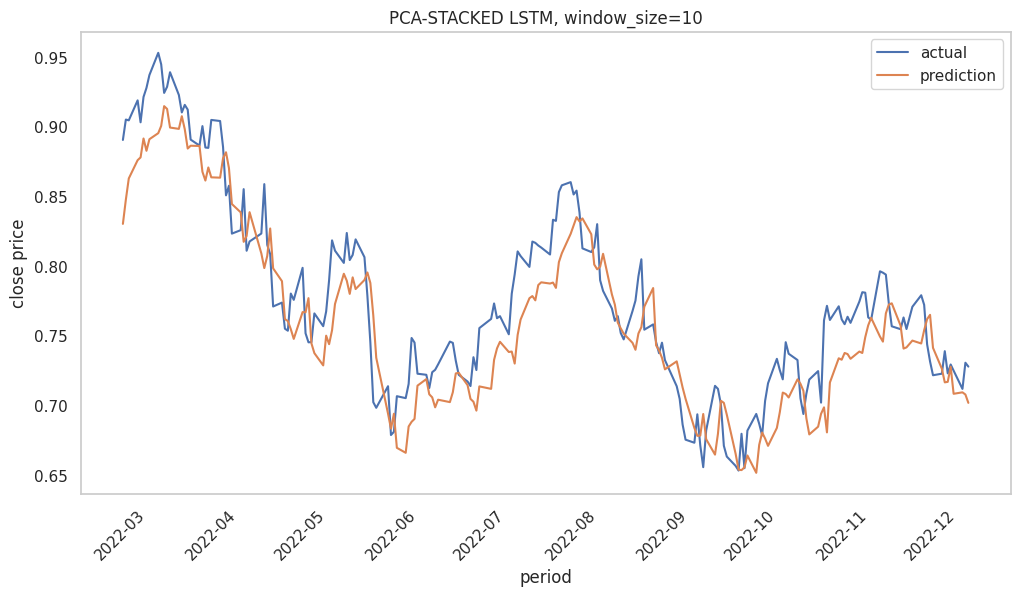

In [ ]:
#stacked_pred = stacked_lstm_model.predict(X_p_test)
plt.figure(figsize=(12, 6))
plt.title('PCA-STACKED LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(test_dates,y_p_test, label='actual')
plt.plot(test_dates,stacked_pred, label='prediction')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='best')

plt.show()
#Graph with scaled X and y

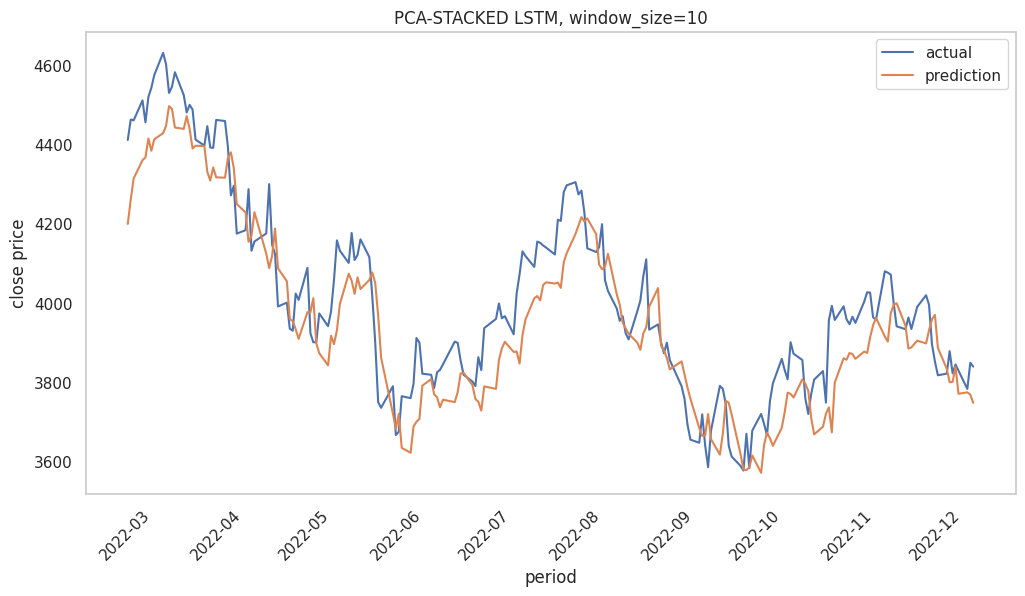

In [ ]:
#Real values of prediction
plt.figure(figsize=(12, 6))
plt.title('PCA-STACKED LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(test_dates,y_pca_test_original, label='actual')
plt.plot(test_dates,y_pca_pred_original, label='prediction')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='best')

plt.show()

In [ ]:
# Calculate error metrics
real_rmse_stacked = np.sqrt(mean_squared_error(y_pca_test_original, y_pca_pred_original))
real_mae_stacked = mean_absolute_error(y_pca_test_original, y_pca_pred_original)
real_mape_stacked = mean_absolute_percentage_error(y_pca_test_original, y_pca_pred_original)

# Print each value
print("RMSE of PCA-Stacked-LSTM :", real_rmse_stacked)
print("MAE of PCA-Stacked-LSTM :", real_mae_stacked)
print("MAPE of PCA-Stacked-LSTM :", real_mape_stacked)

RMSE of PCA-Stacked-LSTM : 107.54789166408487
MAE of PCA-Stacked-LSTM : 89.928623046875
MAPE of PCA-Stacked-LSTM : 0.022282412621921516


In [ ]:
# # Plot the training loss and validation loss over the epochs
# plt.figure(figsize=(5, 5))
# plt.plot(history_pb.history['loss'])
# plt.plot(history_pb.history['val_loss'])
# plt.title('Training Loss vs. Validation Loss of PCA-STACKED-LSTM')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
# plt.show()

# SHAP of PCA LSTM

In [ ]:
# Use the training data for deep explainer => can use fewer instances
explainer_stock_pca = shap.DeepExplainer(stacked_lstm_model, X_p_train)
shap_values_stock_pca = explainer_stock_pca.shap_values(X_p_test)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



In [ ]:
# Use the training data for deep explainer => can use fewer instances
shap_values_stock_pca[0][0].shape

(10, 11)

In [ ]:
shap_values_2D_pca = shap_values_stock_pca[0].reshape(-1,11)
X_p_test_2D = X_p_test.reshape(-1,11)

shap_values_2D_pca.shape, X_p_test_2D.shape

((2000, 11), (2000, 11))

In [ ]:
features = ['Principal_Component_' + str(i) for i in range(1, X_p_test.shape[-1]+1)]
features

['Principal_Component_1',
 'Principal_Component_2',
 'Principal_Component_3',
 'Principal_Component_4',
 'Principal_Component_5',
 'Principal_Component_6',
 'Principal_Component_7',
 'Principal_Component_8',
 'Principal_Component_9',
 'Principal_Component_10',
 'Principal_Component_11']

In [ ]:
X_p_test_2D = pd.DataFrame(data=X_p_test_2D, columns = actual_column_names)

In [ ]:
# X_p_test_2D

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


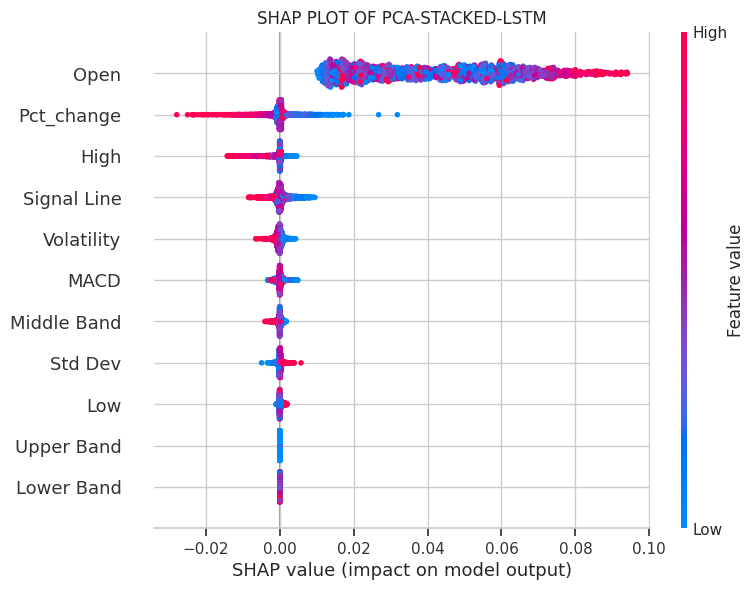

In [ ]:
shap.summary_plot(shap_values_2D_pca, X_p_test_2D, show = False)
plt.title("SHAP PLOT OF PCA-STACKED-LSTM", loc='center')
plt.show()

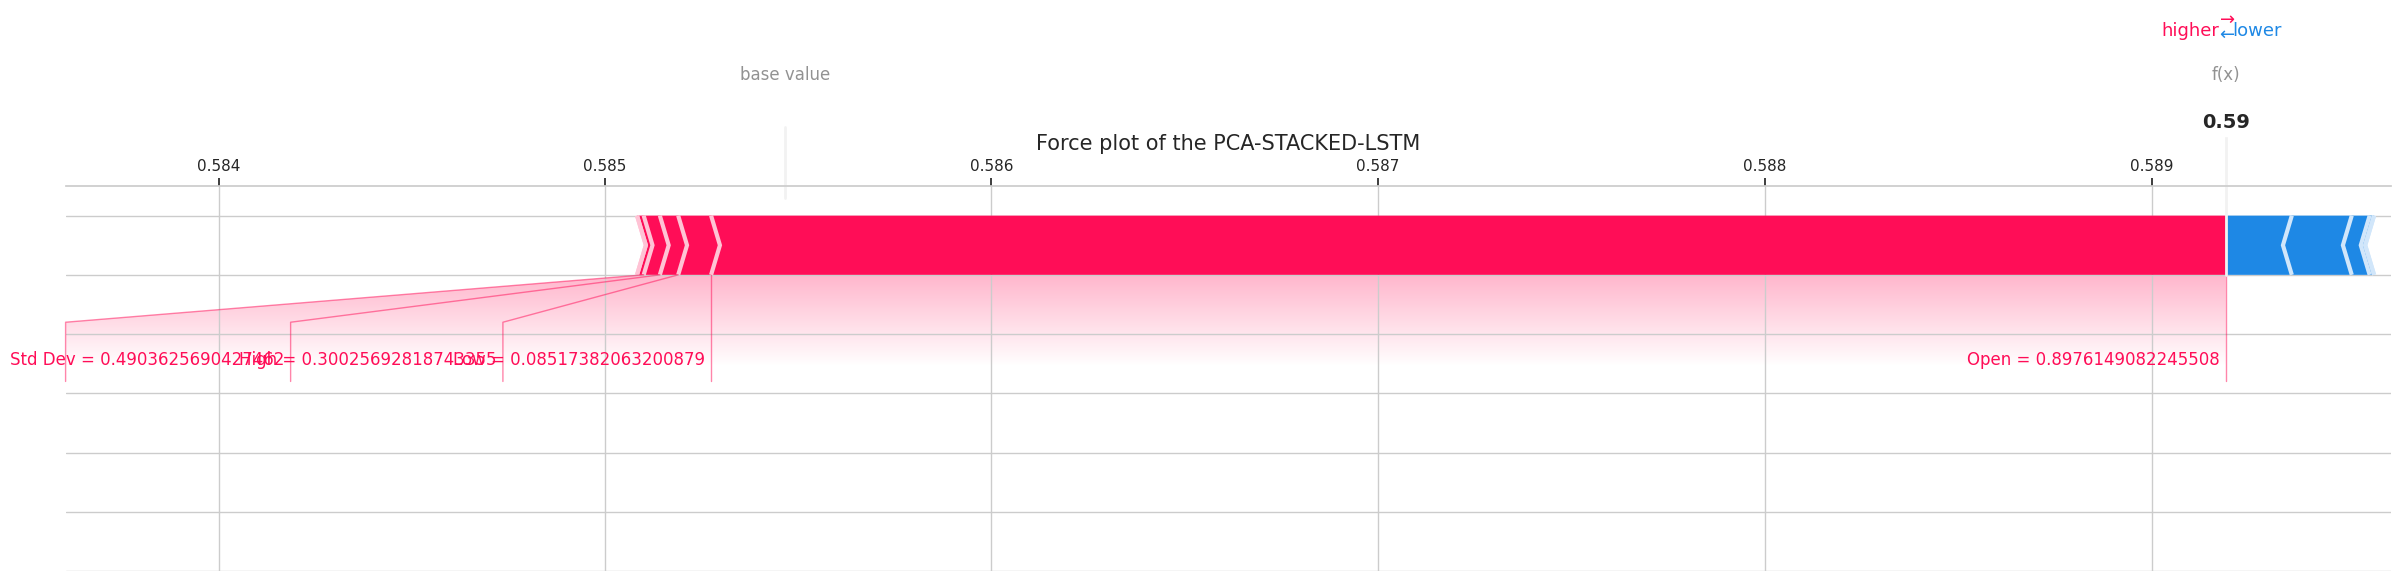

In [ ]:
#Force_plot of the PCA-LSTM
expected_value_stock_pca = explainer_stock_pca.expected_value[0]

instance_index = 0
shap.force_plot(expected_value_stock_pca, shap_values_2D_pca[instance_index], X_p_test_2D.iloc[instance_index],
                link='logit', matplotlib=True,show = False,figsize=(30,5))

plt.title("Force plot of the PCA-STACKED-LSTM",fontsize=15)
plt.show()


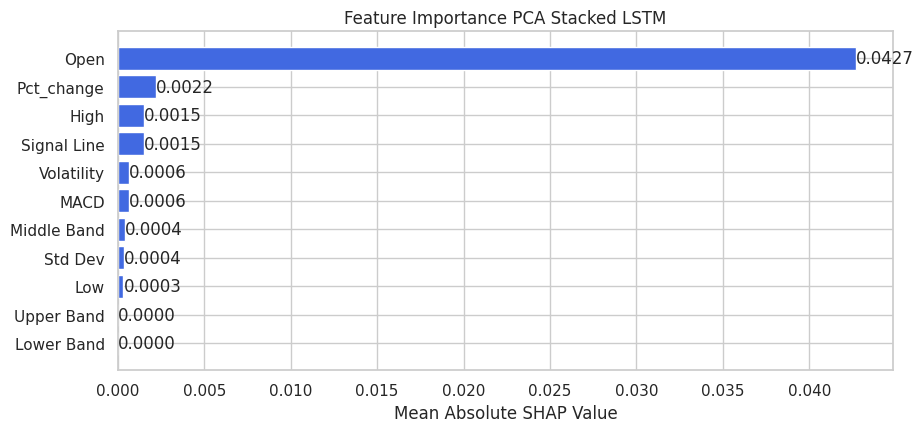

In [ ]:
# Compute the mean absolute SHAP values for each feature
mean_shap_values_pc = np.abs(shap_values_2D_pca).mean(axis=0)

# Sorting the features based on their mean absolute SHAP values
sorted_indices_pc = np.argsort(mean_shap_values_pc)[::-1]
sorted_features_pc = X_p_test_2D.columns[sorted_indices_pc]
sorted_shap_values_pc = mean_shap_values_pc[sorted_indices_pc]

# Create the bar plot
plt.figure(figsize=(10, len(sorted_features_pc) * 0.4))
plt.barh(sorted_features_pc, sorted_shap_values_pc, color='royalblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance PCA Stacked LSTM')

# Annotate each bar with its exact value
for index, value in enumerate(sorted_shap_values_pc):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

# Regular Stacked LSTM Model

In [ ]:
def build_stacked_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])  # Assuming X_p_train has the correct shape
normal_stacked_lstm_model = build_stacked_lstm_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
# Train the model
history_RS = normal_stacked_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])
#RS=Regular Stacked

In [ ]:
normal_stacked_pred = normal_stacked_lstm_model.predict(X_test)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


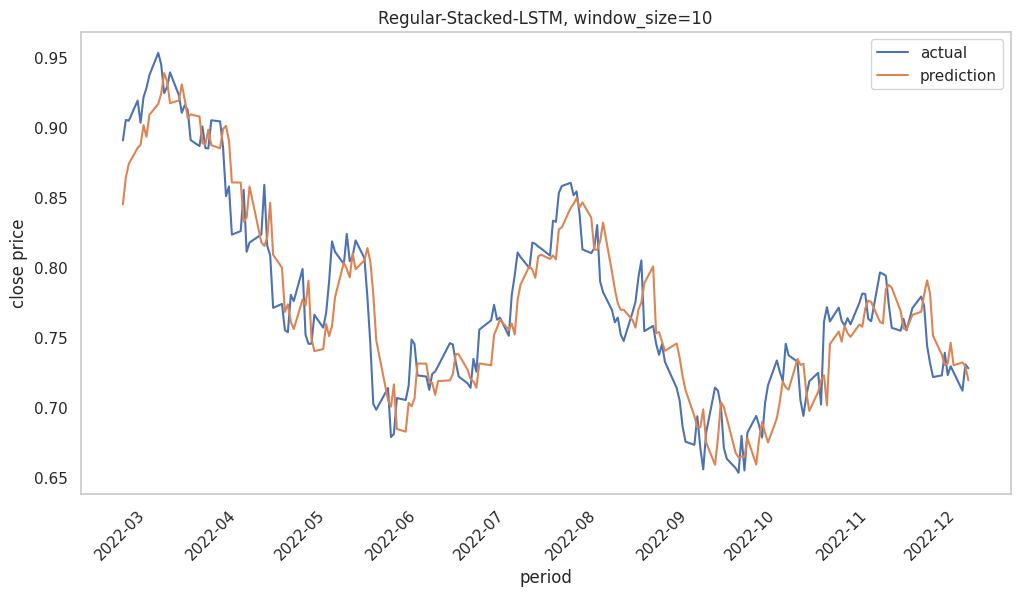

In [ ]:
#stacked_pred = stacked_lstm_model.predict(X_p_test)
plt.figure(figsize=(12, 6))
plt.title('Regular-Stacked-LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(test_dates,y_test, label='actual')
plt.plot(test_dates,normal_stacked_pred, label='prediction')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='best')

plt.show()

In [ ]:
y_nstacked_pred_original = y_scaler.inverse_transform(normal_stacked_pred)
y_nstacked_test_original = y_scaler.inverse_transform(y_test)

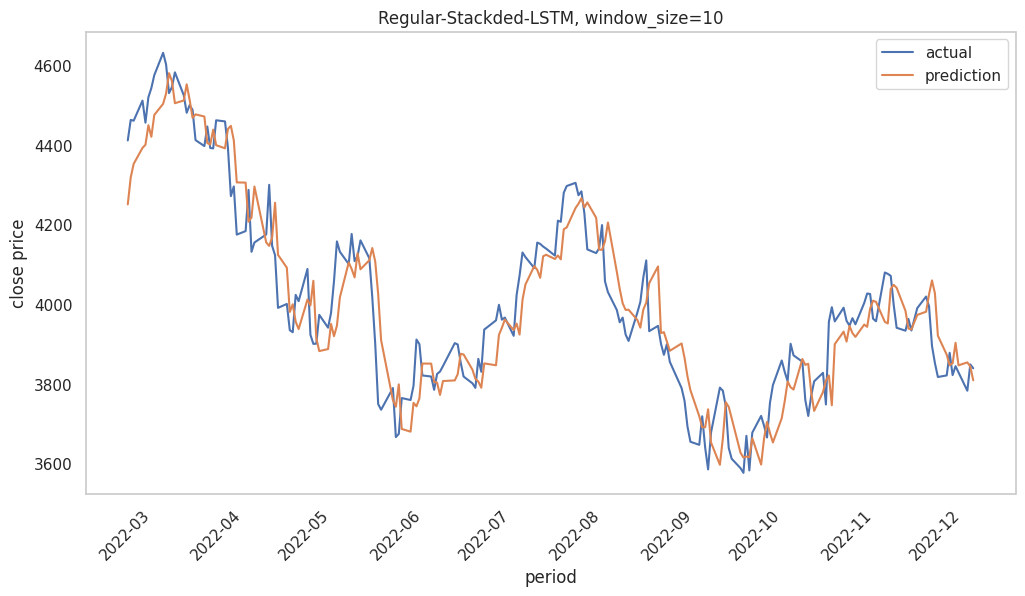

In [ ]:
#Real values of prediction
plt.figure(figsize=(12, 6))
plt.title('Regular-Stackded-LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(test_dates,y_nstacked_test_original, label='actual')
plt.plot(test_dates,y_nstacked_pred_original, label='prediction')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='best')

plt.show()

In [ ]:
# Plot the training loss and validation loss over the epochs
# plt.figure(figsize=(5, 5))
# plt.plot(history_RS.history['loss'])
# plt.plot(history_RS.history['val_loss'])
# plt.title('Training Loss vs. Validation Loss of Regular-STACKED-LSTM')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
# plt.show()

In [ ]:
# Calculate error metrics
real_rmse_rstacked = np.sqrt(mean_squared_error(y_nstacked_test_original, y_nstacked_pred_original))
real_mae_rstacked = mean_absolute_error(y_nstacked_test_original, y_nstacked_pred_original)
real_mape_rstacked = mean_absolute_percentage_error(y_nstacked_test_original, y_nstacked_pred_original)

# Print each value
print("RMSE of Regular-Stacked-LSTM :", real_rmse_rstacked)
print("MAE of Regular-Stacked-LSTM :", real_mae_rstacked)
print("MAPE of Regular-Stacked-LSTM :", real_mape_rstacked)

RMSE of Regular-Stacked-LSTM : 89.4019216465841
MAE of Regular-Stacked-LSTM : 73.2839123535156
MAPE of Regular-Stacked-LSTM : 0.018335233858634465


# SHAP of Regular Stacked LSTM

In [ ]:
# Use the training data for deep explainer
explainer_stock_RS = shap.DeepExplainer(normal_stacked_lstm_model, X_train)
shap_values_stock_RS = explainer_stock_RS.shap_values(X_test)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [ ]:
shap_values_stock_RS[0][0].shape

(10, 11)

In [ ]:
shap_values_RS_2D = shap_values_stock_RS[0].reshape(-1,11)
X_test_RS_2D = X_test.reshape(-1,11)

shap_values_RS_2D.shape, X_test_RS_2D.shape

((2000, 11), (2000, 11))

In [ ]:
X_test_RS_2D = pd.DataFrame(data=X_test_RS_2D, columns = actual_column_names)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


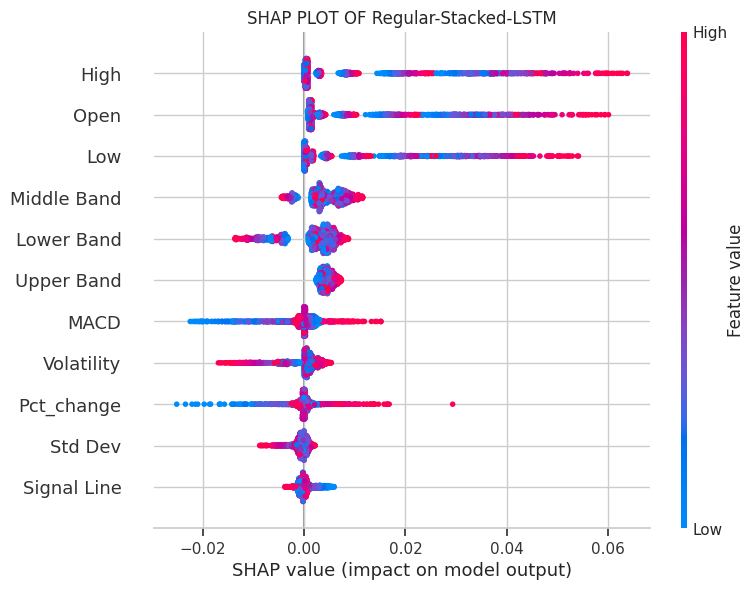

In [ ]:
shap.summary_plot(shap_values_RS_2D, X_test_RS_2D, show = False)
plt.title("SHAP PLOT OF Regular-Stacked-LSTM", loc='center')
plt.show()

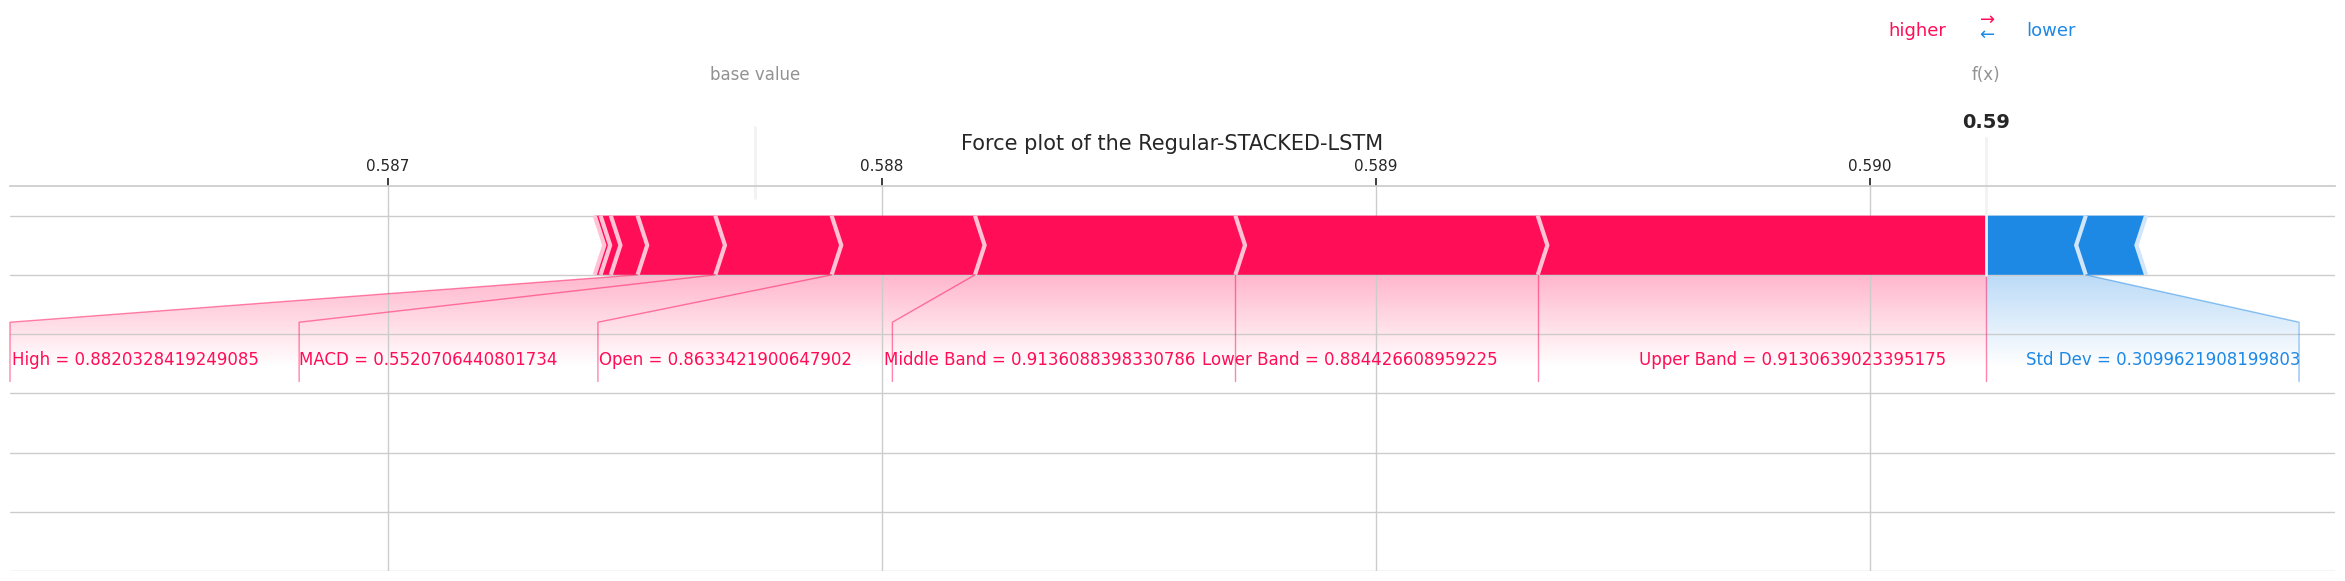

In [ ]:
#Force_plot of the PCA-LSTM
expected_value_stock_RS = explainer_stock_RS.expected_value[0]

instance_index = 0
shap.force_plot(expected_value_stock_RS, shap_values_RS_2D[instance_index], X_test_RS_2D.iloc[instance_index],
                link='logit', matplotlib=True,show = False,figsize=(30,5))

plt.title("Force plot of the Regular-STACKED-LSTM",fontsize=15)
plt.show()

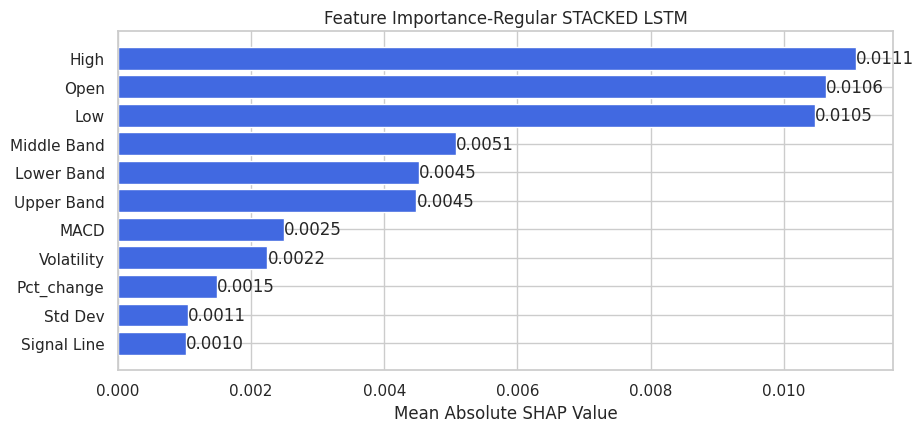

In [ ]:
# Compute the mean absolute SHAP values for each feature
mean_shap_values_rs = np.abs(shap_values_RS_2D).mean(axis=0)

# Sort the features based on their mean absolute SHAP values
sorted_indices_rs = np.argsort(mean_shap_values_rs)[::-1]
sorted_features_rs = X_test_RS_2D.columns[sorted_indices_rs]
sorted_shap_values_rs = mean_shap_values_rs[sorted_indices_rs]

# Create the bar plot
plt.figure(figsize=(10, len(sorted_features_rs) * 0.4))
plt.barh(sorted_features_rs, sorted_shap_values_rs, color='royalblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance-Regular STACKED LSTM')

# Annotate each bar with its exact value
for index, value in enumerate(sorted_shap_values_rs):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

**bold text**# Normal GRU Model

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)


# Importing libraries
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.optimizers import Adam
from keras.layers import Dropout

# The GRU architecture
GRU_model = Sequential()

# First GRU layer with Dropout regularisation
GRU_model.add(GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1], 11), activation='tanh'))
GRU_model.add(Dropout(0.3))

# Second GRU layer
GRU_model.add(GRU(units=64, return_sequences=True, activation='tanh'))
GRU_model.add(Dropout(0.3))

# Third GRU layer
GRU_model.add(GRU(units=64, return_sequences=True, activation='tanh'))
GRU_model.add(Dropout(0.3))

# Fourth GRU layer
GRU_model.add(GRU(units=64, activation='tanh'))
GRU_model.add(Dropout(0.3))

# The output layer
GRU_model.add(Dense(units=1))

# Compiling the RNN
#GRU_model.compile(optimizer=SGD(learning_rate=0.001, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')
GRU_model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=False), loss='mean_squared_error')

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Fitting to the training set
gru_history = GRU_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


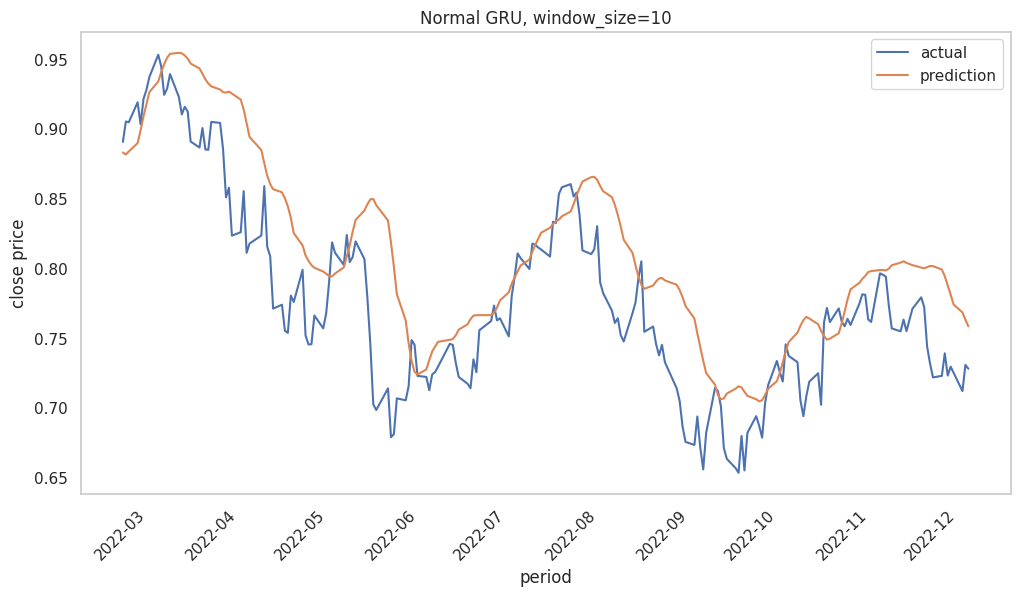

In [ ]:
gru_pred = GRU_model.predict(X_test)
plt.figure(figsize=(12, 6))
plt.title('Normal GRU, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(test_dates,y_test, label='actual')
plt.plot(test_dates,gru_pred, label='prediction')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='best')

plt.show()


In [ ]:
y_pred_gru_original = y_scaler.inverse_transform(gru_pred)
y_test_gru_original = y_scaler.inverse_transform(y_test)

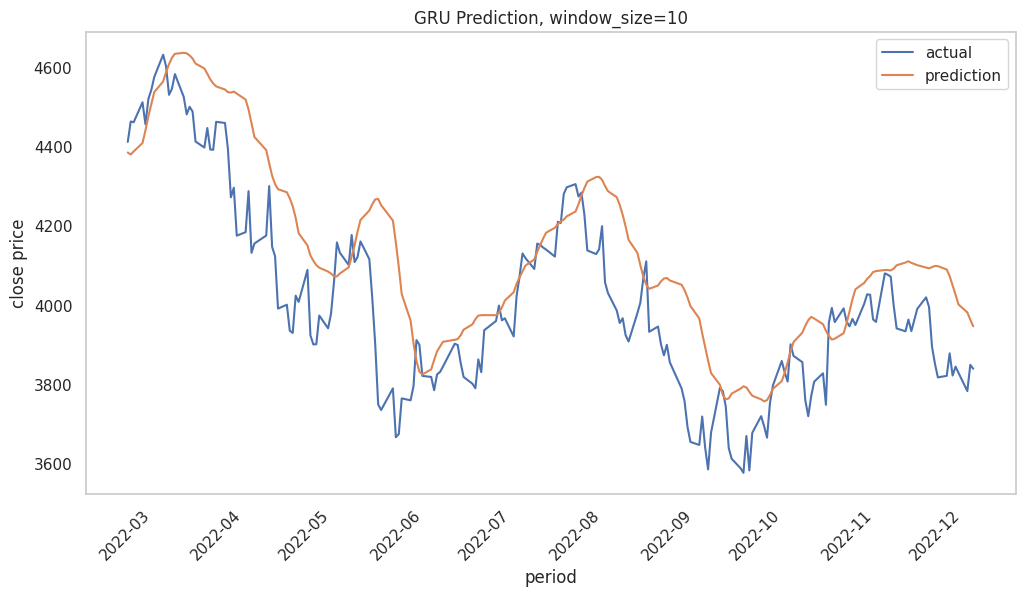

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('GRU Prediction, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(test_dates,y_test_gru_original, label='actual')
plt.plot(test_dates,y_pred_gru_original, label='prediction')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='best')

plt.show()

In [ ]:
# # Plot the training loss and validation loss over the epochs
# plt.figure(figsize=(5, 5))
# plt.plot(gru_history.history['loss'])
# plt.plot(gru_history.history['val_loss'])
# plt.title('Training Loss vs. Validation Loss of GRU')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
# plt.show()

In [ ]:
# Calculate metrics with the real number value
real_rmse_gru = np.sqrt(mean_squared_error(y_test_gru_original, y_pred_gru_original))
real_mae_gru = mean_absolute_error(y_test_gru_original, y_pred_gru_original)
real_mape_gru = mean_absolute_percentage_error(y_test_gru_original, y_pred_gru_original)
#Print each value
print("RMSE of GRU:", real_rmse_gru)
print("MAE of GRU:",real_mae_gru)
print("MAPE of GRU:", real_mape_gru)

RMSE of GRU: 171.71500724364253
MAE of GRU: 133.82623413085938
MAPE of GRU: 0.03399733755255339


# SHAP GRU

In [ ]:
# Use the training data for deep explainer
explainer_stock_gru = shap.DeepExplainer(GRU_model, X_train)
shap_values_stock_gru = explainer_stock_gru.shap_values(X_test)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [ ]:
shap_values_stock_gru[0][0].shape

(10, 11)

In [ ]:
shap_values_stock_gru_2D = shap_values_stock_gru[0].reshape(-1,11)
X_test_gru_2D = X_test.reshape(-1,11)

shap_values_stock_gru_2D.shape, X_test_gru_2D.shape

((2000, 11), (2000, 11))

In [ ]:
X_test_gru_2D = pd.DataFrame(data=X_test_gru_2D, columns = actual_column_names)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


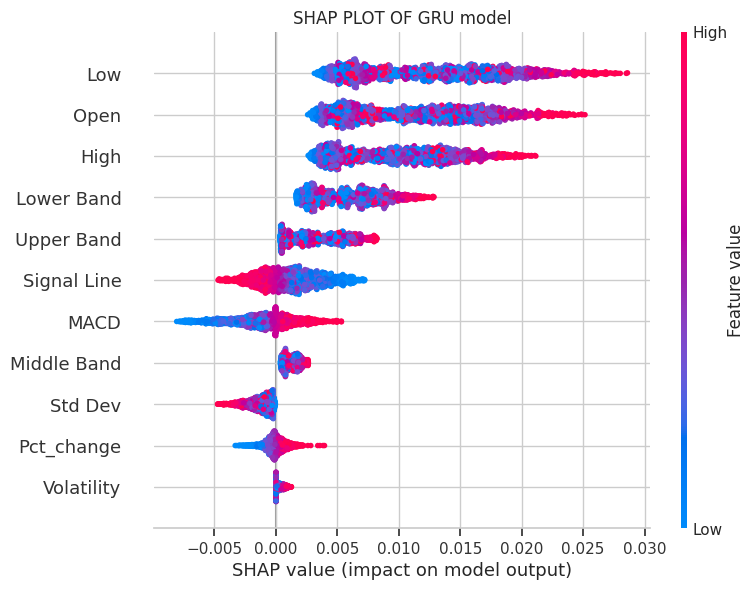

In [ ]:
shap.summary_plot(shap_values_stock_gru_2D, X_test_gru_2D, show = False)
plt.title("SHAP PLOT OF GRU model", loc='center')
plt.show()

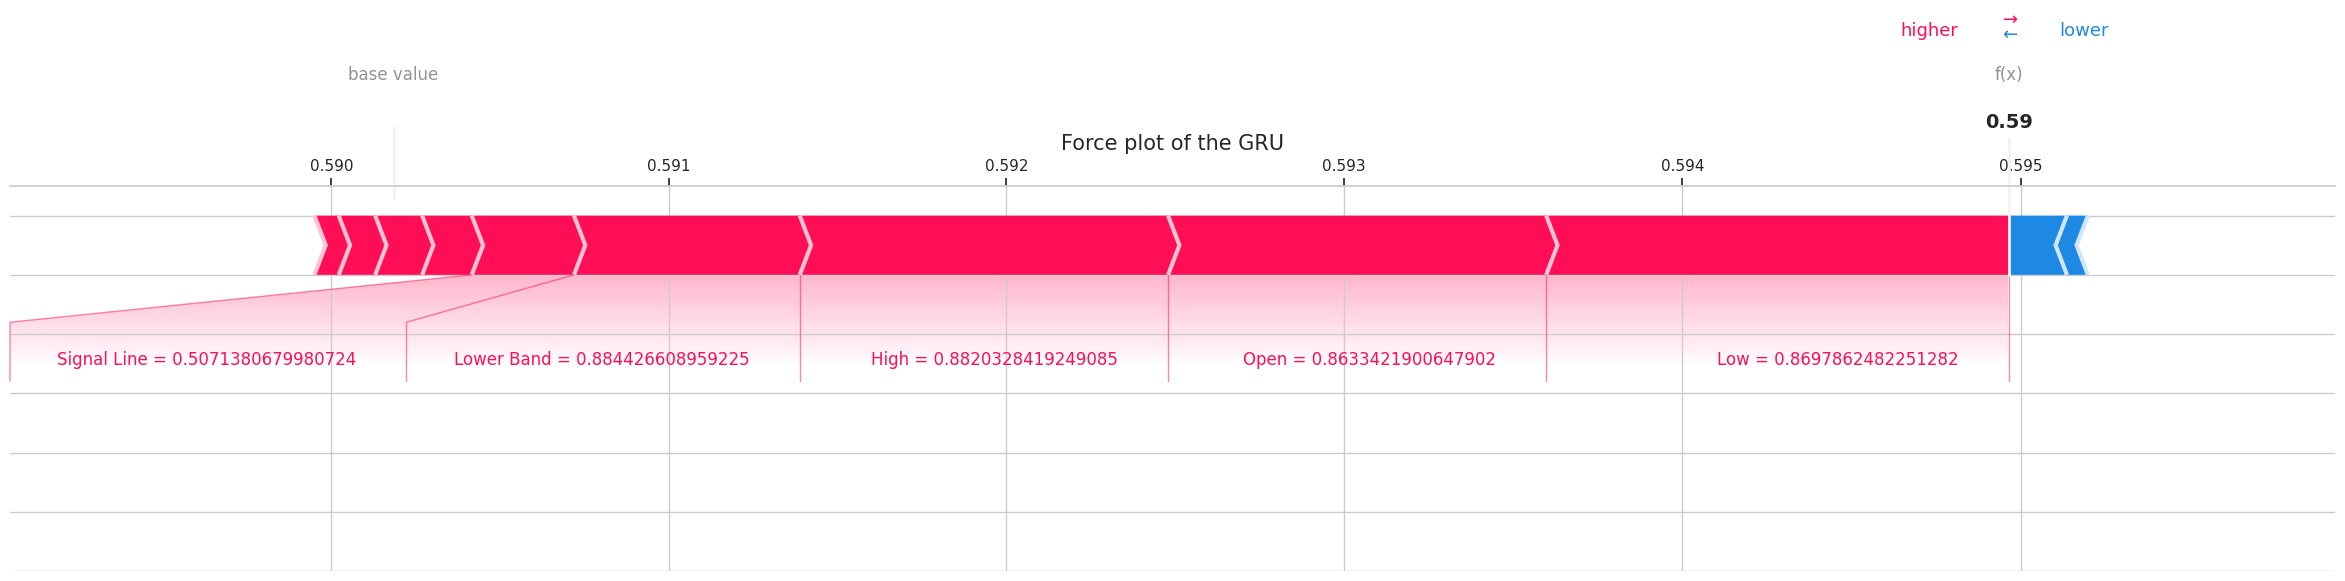

In [ ]:
#Force_plot of the GRU
expected_value_stock_GRU = explainer_stock_gru.expected_value[0]

instance_index = 0
shap.force_plot(expected_value_stock_GRU, shap_values_stock_gru_2D[instance_index], X_test_gru_2D.iloc[instance_index],
                link='logit', matplotlib=True,show = False,figsize=(30,5))

plt.title("Force plot of the GRU",fontsize=15)
plt.show()

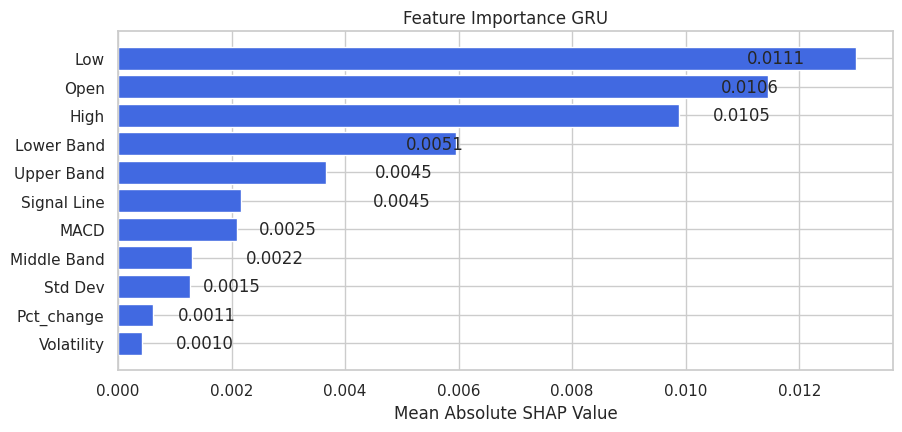

In [ ]:
# Compute the mean absolute SHAP values for each feature
mean_shap_values_gru = np.abs(shap_values_stock_gru_2D).mean(axis=0)

# Sort the features based on their mean absolute SHAP values
sorted_indices_gru = np.argsort(mean_shap_values_gru)[::-1]
sorted_features_gru = X_test_gru_2D.columns[sorted_indices_gru]
sorted_shap_values_gru = mean_shap_values_gru[sorted_indices_gru]

# Create the bar plot
plt.figure(figsize=(10, len(sorted_features_gru) * 0.4))
plt.barh(sorted_features_gru, sorted_shap_values_gru, color='royalblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance GRU')

# Annotate each bar with its exact value
for index, value in enumerate(sorted_shap_values_rs):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

# Machine Learning model, Voting Regressor with TPOT

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score,accuracy_score
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import yfinance as yf
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor,VotingRegressor,RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, Sum,Product,Matern
from xgboost import XGBRegressor
import shap
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
dfm = yf.download('^GSPC', start='2012-01-01', end='2022-12-31')
# dfm

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Making the percentage changes in each day
dfm['Pct_change'] = dfm['Close'].pct_change()
dfm['Pct_change'] = np.log1p(dfm['Pct_change'])

# Choose the desired time periods for the moving averages
short_period = 12  # Short-term EMA period
long_period = 26  # Long-term EMA period
signal_period = 9  # Signal line EMA period

# Calculate the short-term EMA
dfm['Short EMA'] = dfm['Close'].ewm(span=short_period, adjust=False).mean()

# Calculate the long-term EMA
dfm['Long EMA'] = dfm['Close'].ewm(span=long_period, adjust=False).mean()

# Calculate the MACD line
dfm['MACD'] = dfm['Short EMA'] - dfm['Long EMA']

# Calculate the signal line
dfm['Signal Line'] = dfm['MACD'].ewm(span=signal_period, adjust=False).mean()

# Calculate the MACD histogram
dfm['MACD Histogram'] = dfm['MACD'] - dfm['Signal Line']

# Calculate the logarithmic returns
dfm['Log Returns'] = np.log(dfm['Close'] / dfm['Close'].shift(1))

# Calculate the volatility
dfm['Volatility'] = dfm['Log Returns'].rolling(window=20).std() * np.sqrt(252)

# desired tDme period for the moving average and standard deviation
window = 20  # Number of Trading days in a month
num_std = 2
# 2 standard deviations above and below the middle band provides
# a range that encompasses a large portion of typical price movements

# Calculate the middle band (simple moving average)
dfm['Middle Band'] = dfm['Close'].rolling(window=window).mean()

# Calculate the standard deviation of the closing prices
dfm['Std Dev'] = dfm['Close'].rolling(window=window).std()

# Calculate the upper band and lower band
dfm['Upper Band'] = dfm['Middle Band'] + (num_std * dfm['Std Dev'])
dfm['Lower Band'] = dfm['Middle Band'] - (num_std * dfm['Std Dev'])

# Making Next day's close price column in each date.
dfm['Next_day'] = dfm['Close'].shift(-1)


In [ ]:
# dfm

In [ ]:
dfm.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Pct_change         1
Short EMA          0
Long EMA           0
MACD               0
Signal Line        0
MACD Histogram     0
Log Returns        1
Volatility        20
Middle Band       19
Std Dev           19
Upper Band        19
Lower Band        19
Next_day           1
dtype: int64

In [ ]:
dfm = dfm.dropna()

# Drop unimportant features for VR

In [ ]:
dfm = dfm.drop(["Adj Close","Volume","Close",'Short EMA','Log Returns', 'Long EMA', 'MACD Histogram'],axis = 1)

In [ ]:
features_v = dfm.columns

In [ ]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Pct_change', 'MACD','Signal Line','Volatility','Middle Band', 'Std Dev',
       'Upper Band', 'Lower Band']

scaled_df_v = scaler.fit_transform(dfm[scale_cols])

scaled_df_v = pd.DataFrame(scaled_df_v, columns=scale_cols)

# print(scaled_df_v)

In [ ]:
# PCA
n_components_v = 11
pca_v = PCA(n_components=n_components_v)
X_pca_v = pca_v.fit_transform(scaled_df_v)

In [ ]:
X_pca_v.shape

(2747, 11)

In [ ]:
X_pca_df_v = pd.DataFrame(X_pca_v)
# X_pca_df_v

## Split into X and y for ML Model

In [ ]:
X_v = X_pca_v
# For the target variable, assume you still want to predict 'Next_day'
y_v = dfm['Next_day'].values

# Convert to numpy arrays
X_v = np.array(X_v)
y_v = np.array(y_v)

X_v.shape, y_v.shape

((2747, 11), (2747,))

In [ ]:
# Access the principal components
principal_components = pca_v.components_

# Access the explained variance of each principal component
explained_variances = pca_v.explained_variance_ratio_

# Print the explained variance of each principal component
for i, explained_variance in enumerate(explained_variances):
    print(f"Principal Component {i+1}: {explained_variance:.4f}")

# Print the loadings of the original features on each principal component
features_v = scaled_df_v.columns  # Assuming features_v are the columns of scaled_df_v
for i, pc in enumerate(principal_components):
    print(f"Principal Component {i+1} Loadings:")
    for feature, loading in zip(features_v, pc):
        print(f"{feature}: {loading:.4f}")

In [ ]:
X_v.shape, y_v.shape

((2747, 11), (2747,))

In [ ]:
# Scale the input sequences (X)
scaler = MinMaxScaler()
X_v = scaler.fit_transform(X_v.reshape(X_v.shape[0], -1))

# Scale the target variable (y)
y_scaler = MinMaxScaler()
y_v = y_scaler.fit_transform(y_v.reshape(-1, 1))


In [ ]:
y_v

array([[0.01349999],
       [0.0190023 ],
       [0.01884028],
       ...,
       [0.7119982 ],
       [0.73077316],
       [0.72799357]])

In [ ]:
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=200)
for train_index, test_index in tscv.split(X, y):
    X_vtrain, X_vtest = X_v[train_index], X_v[test_index]
    y_vtrain, y_vtest = y_v[train_index], y_v[test_index]

In [ ]:
print(X_vtrain.shape, X_vtest.shape,y_vtrain.shape, y_vtest.shape)

(2537, 11) (200, 11) (2537, 1) (200, 1)


In [ ]:
y_train

array([[0.02273683],
       [0.02364345],
       [0.02392197],
       ...,
       [0.82280897],
       [0.84820042],
       [0.87531684]])

In [ ]:
X_vtrain_2d = X_train.reshape((X_train.shape[0], -1))
X_vtest_2d = X_test.reshape((X_test.shape[0], -1))
# Fit the PCA on your training data and apply the dimensionality reduction
X_vtrain_pca = pca_v.fit_transform(X_vtrain_2d)

# Apply the same transformation to your test data
X_vtest_pca = pca_v.transform(X_vtest_2d)

# Voting Regressor Ensemble

In [ ]:
!pip install tpot

In [ ]:
from tpot.config import regressor_config_dict
from tpot import TPOTRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.ensemble import VotingRegressor

In [ ]:
cv_split = TimeSeriesSplit(n_splits=10, test_size=200)

models = [
     (GaussianProcessRegressor(), {
        "kernel": [DotProduct(),WhiteKernel()],
        "n_restarts_optimizer": [2,5],
        "alpha": [1e-10, 1e-5, 1e-1]
    })
]

vr_estimators = {}
for model, parameters in models:
    grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
    grid_search.fit(X_vtrain_pca, y_train)
    vr_estimators.update([(model.__class__.__name__, grid_search.best_estimator_)])

In [ ]:
# Define the TPOT configurations for each model
np.random.seed(123)

tpot_config = {
    'xgboost.XGBRegressor': {
        "max_depth": [3, 10,20],
        "learning_rate": [0.01, 0.1],
        "n_estimators": [100, 300],
        "colsample_bytree": [0.5, 1]
    },
    'lightgbm.LGBMRegressor': {
        "max_depth": [3, 10,20],
        "num_leaves": [10,30,50],
        "learning_rate": [0.01, 0.1],
        "n_estimators": [100, 300],
        "colsample_bytree": [0.5, 1]
    },
    'sklearn.svm.SVR': {
        "epsilon": [0.1, 0.2, 0.5],
        "kernel": ['linear', 'poly', 'rbf'],
        "gamma": ['scale', 'auto']
    }

}

best_models = {}

# Loop through the model configurations and find the best model for each
for model_name, config in tpot_config.items():
    tpot = TPOTRegressor(generations=2, population_size=10, verbosity=2, config_dict={model_name: config})
    tpot.fit(X_vtrain_pca, y_train)

    # Get the best model from TPOT
    best_model = tpot.fitted_pipeline_

    # Store the best model in the dictionary
    best_models[model_name] = best_model

In [ ]:
vr_estimators.update(best_models)

In [ ]:
vr_estimators = [(model_name, model) for model_name, model in vr_estimators.items()]
vr = VotingRegressor(estimators=vr_estimators)
vr.fit(X_vtrain_pca, y_train)

In [ ]:
y_pred_reg = vr.predict(X_vtest_pca)

In [ ]:
X_vtest_pca.shape

(200, 11)

In [ ]:
# x_reg_columns = X_vtest_pca.columns

In [ ]:
y_pred_inv = y_scaler.inverse_transform(y_pred_reg.reshape(-1,1))
#y_test_originalv = y_scaler.inverse_transform(y_vtest)
y_test_originalv = y_scaler.inverse_transform(y_test)

In [ ]:
# Calculate metrics
rmse_vr = np.sqrt(mean_squared_error(y_test_originalv, y_pred_inv))
mae_vr = mean_absolute_error(y_test_originalv, y_pred_inv)
mape_vr = mean_absolute_percentage_error(y_test_originalv, y_pred_inv)

print("RMSE of Voting Regressor:", rmse_vr)
print("MAE of Voting Regressor:", mae_vr)
print("MAPE of Voting Regressor:", mape_vr)

RMSE of Voting Regressor: 113.5493982964325
MAE of Voting Regressor: 91.20745936952324
MAPE of Voting Regressor: 0.022872997991886867


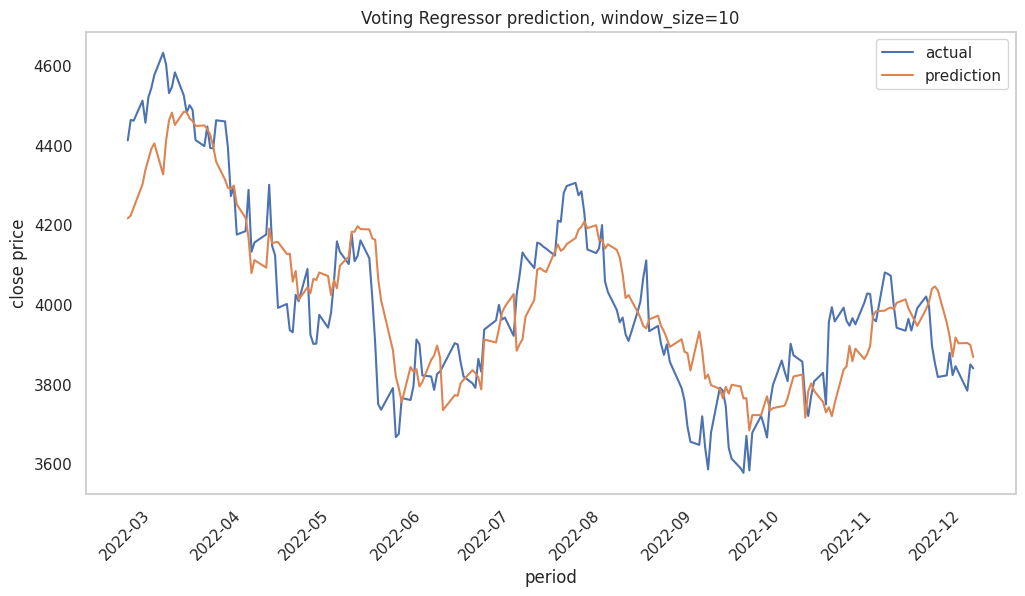

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Voting Regressor prediction, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(test_dates,y_test_originalv, label='actual')
plt.plot(test_dates,y_pred_inv, label='prediction')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='best')

plt.show()

# SHAP of Voting Regressor

In [ ]:
features_vt = ['Principal_Component_' + str(i) for i in range(1, X_vtest_pca.shape[-1]+1)]
features_vt

['Principal_Component_1',
 'Principal_Component_2',
 'Principal_Component_3',
 'Principal_Component_4',
 'Principal_Component_5',
 'Principal_Component_6',
 'Principal_Component_7',
 'Principal_Component_8',
 'Principal_Component_9',
 'Principal_Component_10',
 'Principal_Component_11']

  0%|          | 0/200 [00:00<?, ?it/s]

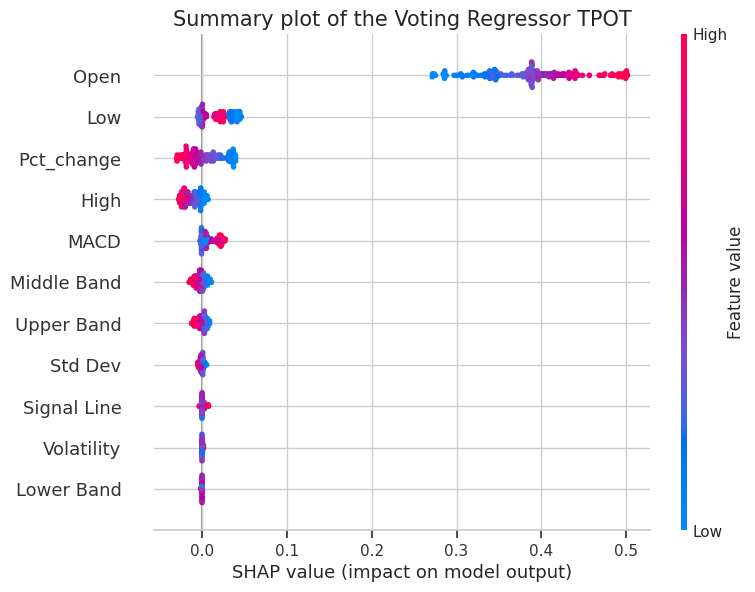

In [ ]:
explainer = shap.KernelExplainer(vr.predict, shap.sample(X_pca_v, 10))  # Using 100 background samples for better performance
x_vtest_2d = np.reshape(X_vtest_pca, (X_vtest_pca.shape[0], X_vtest_pca.shape[1]))
shap_values_vr = explainer.shap_values(x_vtest_2d)

# Plot the SHAP values
#shap.summary_plot(shap_values_vr, x_vtest_2d,feature_names=actual_column_names)
shap.summary_plot(shap_values_vr, x_vtest_2d,feature_names=scale_cols,show = False)
plt.title("Summary plot of the Voting Regressor TPOT",fontsize=15)
plt.show()

In [ ]:
# x_vtest_2d

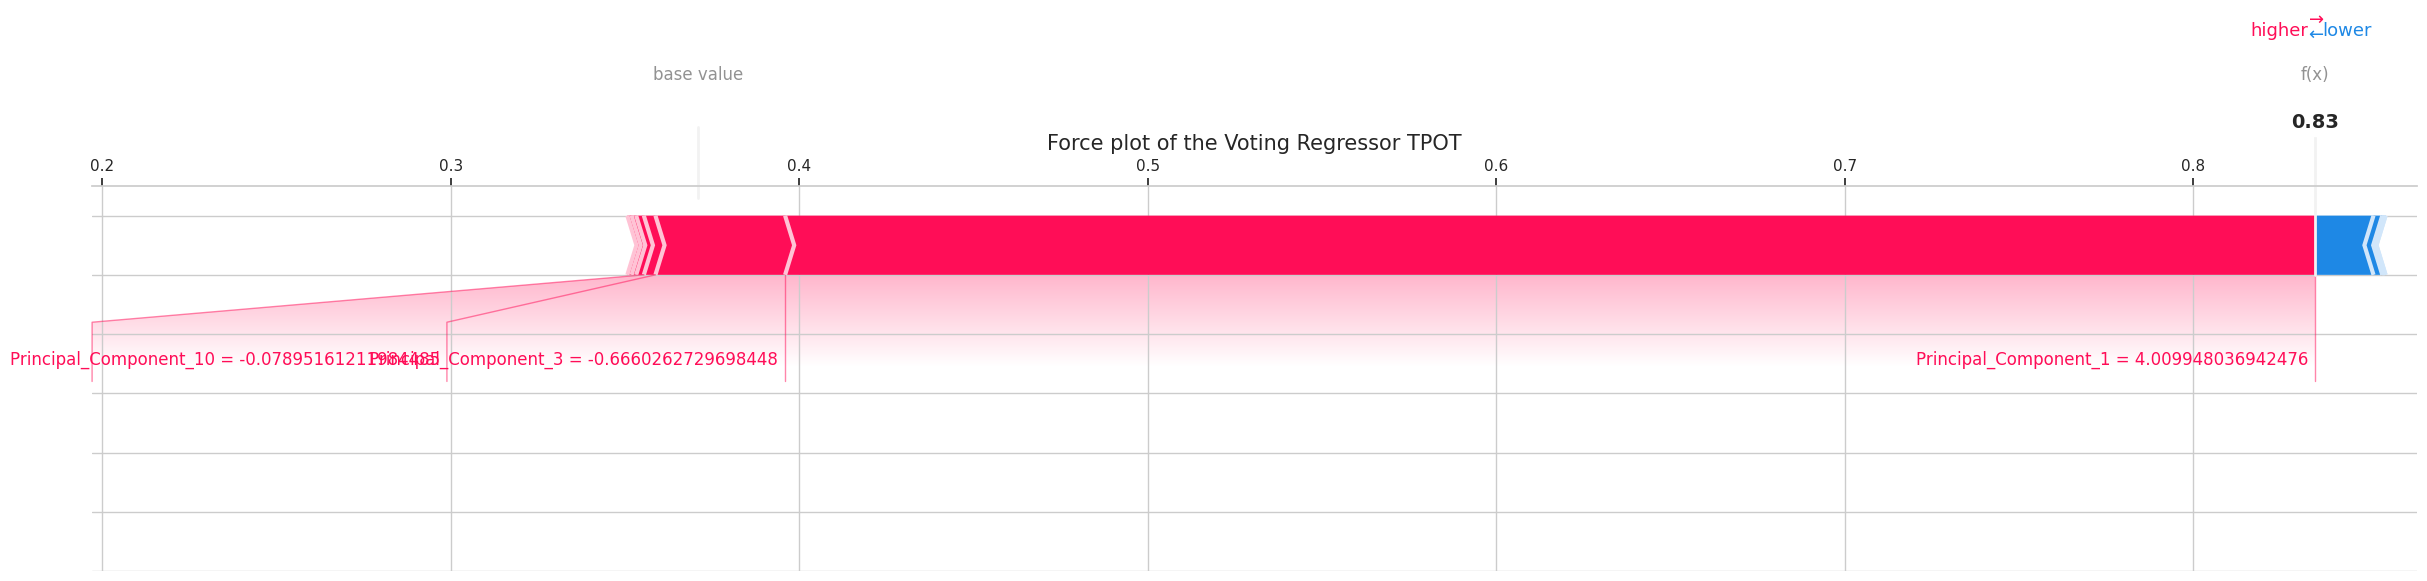

In [ ]:
#Force_plot of the Voting Regressor
expected_value_vr = explainer.expected_value

instance_index = 0

shap.force_plot(expected_value_vr, shap_values_vr[instance_index], x_vtest_2d[instance_index],
                feature_names=features_vt,matplotlib=True,show = False,figsize=(30,5))

plt.title("Force plot of the Voting Regressor TPOT",fontsize=15)
plt.show()

In [ ]:
# X.shape

In [ ]:
x_vtest_2d_df = pd.DataFrame(x_vtest_2d, columns = actual_column_names)

In [ ]:
# x_vtest_2d_df

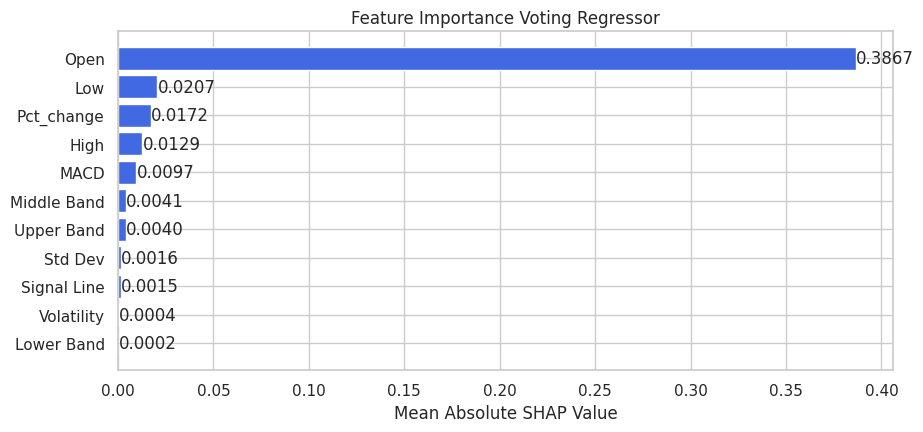

In [ ]:
# Compute the mean absolute SHAP values for each feature
mean_shap_values_vr = np.abs(shap_values_vr).mean(axis=0)

# Sort the features based on their mean absolute SHAP values
sorted_indices_vr = np.argsort(mean_shap_values_vr)[::-1]

# If x_vtest_2d is a DataFrame, you can get the column names directly.
# Otherwise, replace `x_vtest_2d.columns` with appropriate column names.
sorted_features_vr = x_vtest_2d_df.columns[sorted_indices_vr]
sorted_shap_values_vr = mean_shap_values_vr[sorted_indices_vr]

# Create the bar plot
plt.figure(figsize=(10, len(sorted_features_vr) * 0.4))
plt.barh(sorted_features_vr, sorted_shap_values_vr, color='royalblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance Voting Regressor')

# Annotate each bar with its exact value
for index, value in enumerate(sorted_shap_values_vr):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


# Summary of whole model

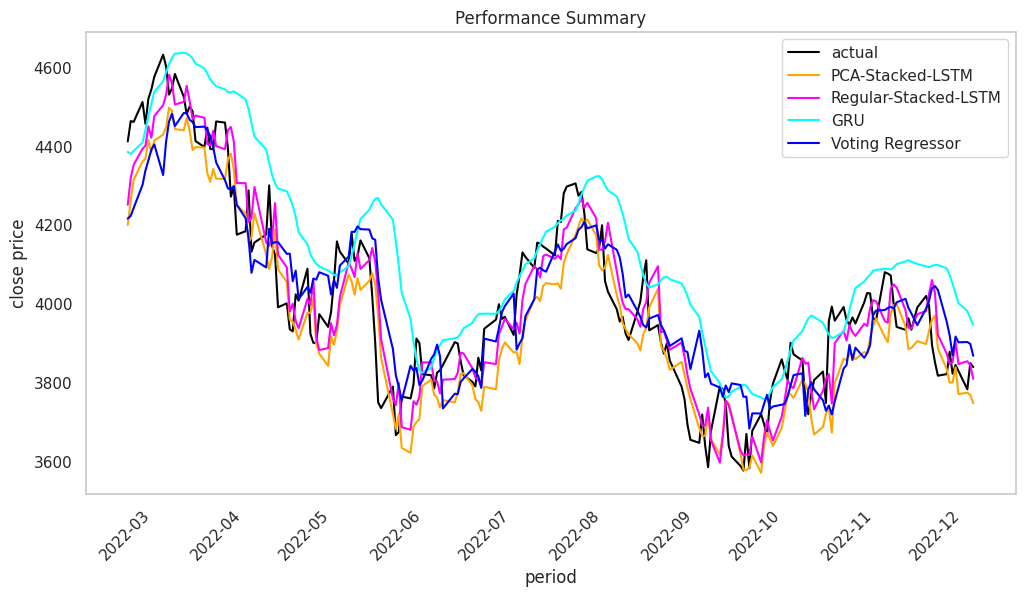

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Performance Summary')
plt.ylabel('close price')
plt.xlabel('period')

plt.plot(test_dates,y_test_original, label='actual', color='black')
plt.plot(test_dates,y_pca_pred_original, label='PCA-Stacked-LSTM', color='orange')
plt.plot(test_dates,y_nstacked_pred_original, label='Regular-Stacked-LSTM', color='magenta')
plt.plot(test_dates,y_pred_gru_original, label='GRU', color='cyan')
plt.plot(test_dates,y_pred_inv, label='Voting Regressor',color = 'blue')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='best')

plt.show()


In [ ]:
#Performance Evaluations
#1. Bidirectional-LSTM
# real_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
# real_mae = mean_absolute_error(y_test_original, y_pred_original)
# real_mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

# print("RMSE of Bidirectional-LSTM:", real_rmse)
# print("MAE of Bidirectional-LSTM:",real_mae)
# print("MAPE of Bidirectional-LSTM:", real_mape)


# #2. Single-Layered LSTM
# real_rmse_single = np.sqrt(mean_squared_error(y_single_test_original, y_single_pred_original))
# real_mae_single = mean_absolute_error(y_single_test_original, y_single_pred_original)
# real_mape_single = mean_absolute_percentage_error(y_single_test_original, y_single_pred_original)

# print("RMSE of Single-Layered-LSTM :", real_rmse_single)
# print("MAE of Single-Layered-LSTM :", real_mae_single)
# print("MAPE of Single-Layered-LSTM :", real_mape_single)



#3. PCA-Stacked-LSTM
real_rmse_stacked = np.sqrt(mean_squared_error(y_pca_test_original, y_pca_pred_original))
real_mae_stacked = mean_absolute_error(y_pca_test_original, y_pca_pred_original)
real_mape_stacked = mean_absolute_percentage_error(y_pca_test_original, y_pca_pred_original)

print("RMSE of PCA-Stacked-LSTM :", real_rmse_stacked)
print("MAE of PCA-Stacked-LSTM :", real_mae_stacked)
print("MAPE of PCA-Stacked-LSTM :", real_mape_stacked)



#4. Regular Stacked LSTM
real_rmse_rstacked = np.sqrt(mean_squared_error(y_nstacked_test_original, y_nstacked_pred_original))
real_mae_rstacked = mean_absolute_error(y_nstacked_test_original, y_nstacked_pred_original)
real_mape_rstacked = mean_absolute_percentage_error(y_nstacked_test_original, y_nstacked_pred_original)

print("RMSE of Regular-Stacked-LSTM :", real_rmse_rstacked)
print("MAE of Regular-Stacked-LSTM :", real_mae_rstacked)
print("MAPE of Regular-Stacked-LSTM :", real_mape_rstacked)


#5. GRU
# Calculate metrics with the real number value
real_rmse_gru = np.sqrt(mean_squared_error(y_test_gru_original, y_pred_gru_original))
real_mae_gru = mean_absolute_error(y_test_gru_original, y_pred_gru_original)
real_mape_gru = mean_absolute_percentage_error(y_test_gru_original, y_pred_gru_original)

print("RMSE of GRU:", real_rmse_gru)
print("MAE of GRU:",real_mae_gru)
print("MAPE of GRU:", real_mape_gru)


#6. Voting Regressor
rmse_vr = np.sqrt(mean_squared_error(y_test_originalv, y_pred_inv))
mae_vr = mean_absolute_error(y_test_originalv, y_pred_inv)
mape_vr = mean_absolute_percentage_error(y_test_originalv, y_pred_inv)

print("RMSE of Voting Regressor:", rmse_vr)
print("MAE of Voting Regressor:", mae_vr)
print("MAPE of Voting Regressor:", mape_vr)

RMSE of PCA-Stacked-LSTM : 107.54789166408487
MAE of PCA-Stacked-LSTM : 89.928623046875
MAPE of PCA-Stacked-LSTM : 0.022282412621921516
RMSE of Regular-Stacked-LSTM : 89.4019216465841
MAE of Regular-Stacked-LSTM : 73.2839123535156
MAPE of Regular-Stacked-LSTM : 0.018335233858634465
RMSE of GRU: 171.71500724364253
MAE of GRU: 133.82623413085938
MAPE of GRU: 0.03399733755255339
RMSE of Voting Regressor: 113.5493982964325
MAE of Voting Regressor: 91.20745936952324
MAPE of Voting Regressor: 0.022872997991886867


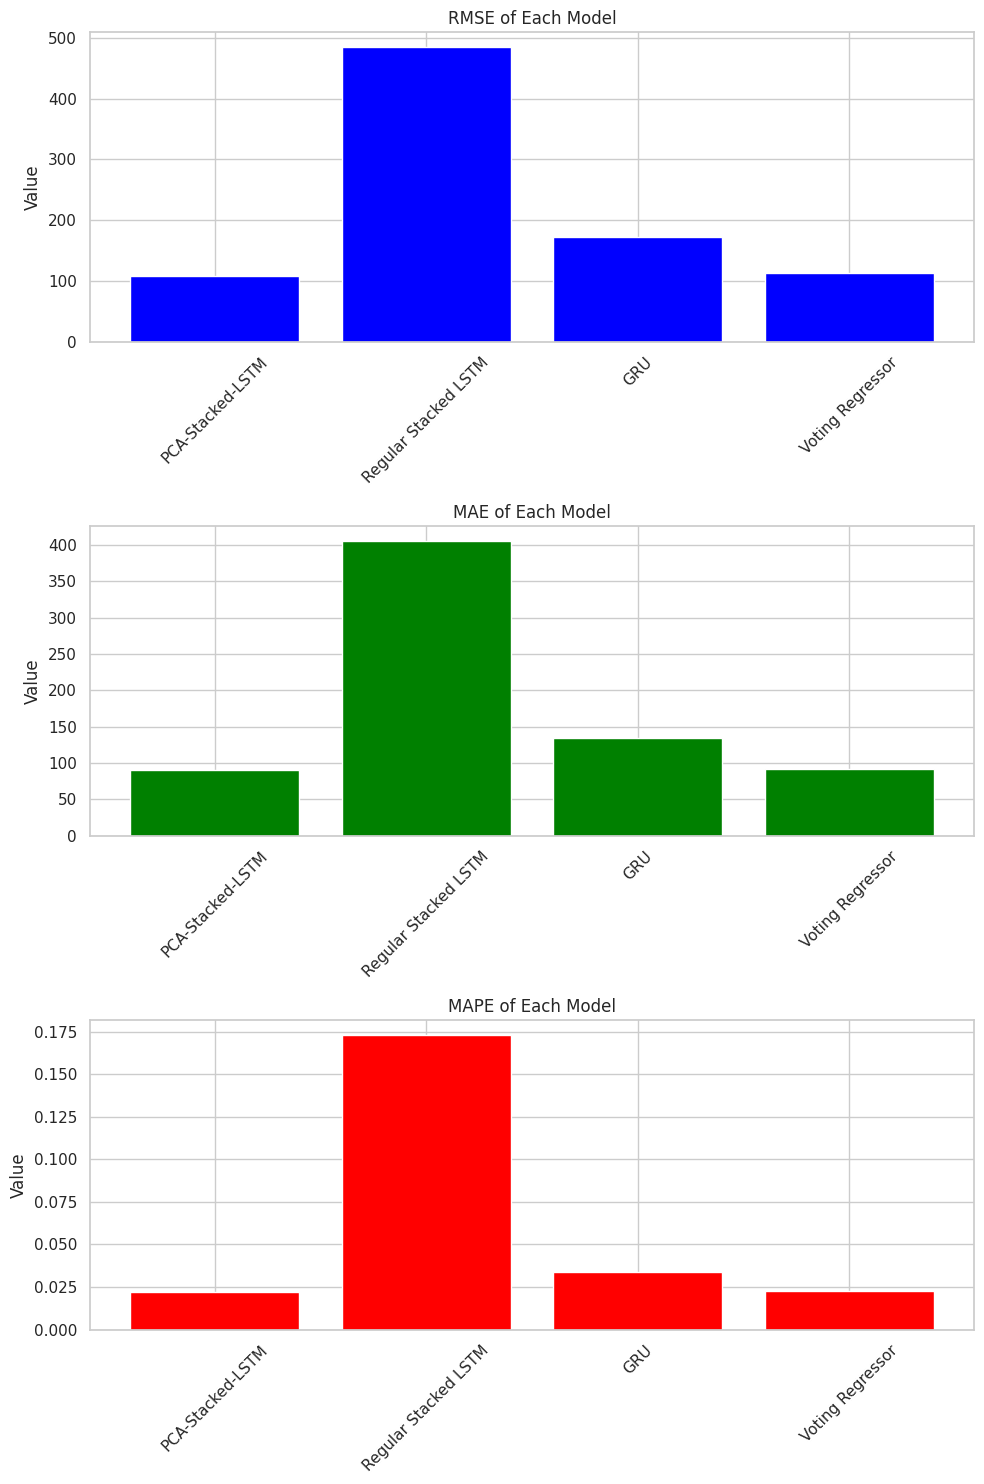

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['PCA-Stacked-LSTM', 'Regular Stacked LSTM', 'GRU', 'Voting Regressor']

# RMSE values
rmse_values = [real_rmse_stacked, real_rmse_rstacked, real_rmse_gru, rmse_vr]

# MAE values
mae_values = [real_mae_stacked, real_mae_rstacked, real_mae_gru, mae_vr]

# MAPE values
mape_values = [real_mape_stacked, real_mape_rstacked, real_mape_gru, mape_vr]

# Create subplots
fig, axs = plt.subplots(3, figsize=(10, 15))

# Create RMSE bar chart
axs[0].bar(models, rmse_values, color='blue')
axs[0].set_title('RMSE of Each Model')
axs[0].set_ylabel('Value')

# Create MAE bar chart
axs[1].bar(models, mae_values, color='green')
axs[1].set_title('MAE of Each Model')
axs[1].set_ylabel('Value')

# Create MAPE bar chart
axs[2].bar(models, mape_values, color='red')
axs[2].set_title('MAPE of Each Model')
axs[2].set_ylabel('Value')

# Rotate x-axis labels for readability
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Testing with unseen data

In [ ]:
df_unseen = yf.download('^KS11', start='2010-01-01', end='2023-06-30')
#df = pd.read_csv("/Users/parkjs9416/Documents/Dissertation/Dissertation_project_code_and_data/Dataset/sp500_10year_data.csv")
df_unseen

In [ ]:
#Making the percentage changes in each day
df_unseen['Pct_change'] = df_unseen['Close'].pct_change()
# data['Pct_change'] = np.log(1+data['Pct_change'])
df_unseen['Pct_change'] = np.log1p(df_unseen['Pct_change'])
# Choose the desired time periods for the moving averages
short_period = 12  # Short-term EMA period
long_period = 26  # Long-term EMA period
signal_period = 9  # Signal line EMA period

# Calculate the short-term EMA
df_unseen['Short EMA'] = df_unseen['Close'].ewm(span=short_period, adjust=False).mean()

# Calculate the long-term EMA
df_unseen['Long EMA'] = df_unseen['Close'].ewm(span=long_period, adjust=False).mean()

# Calculate the MACD line
df_unseen['MACD'] = df_unseen['Short EMA'] - df_unseen['Long EMA']

# Calculate the signal line
df_unseen['Signal Line'] = df_unseen['MACD'].ewm(span=signal_period, adjust=False).mean()

# Calculate the MACD histogram
df_unseen['MACD Histogram'] = df_unseen['MACD'] - df_unseen['Signal Line']
# Choose the desired time period for the moving average and standard deviation
window = 20  # Number of Trading days in a month
num_std = 2
# 2 standard deviations above and below the middle band provides
#a range that encompasses a large portion of typical price movements

# Calculate the logarithmic returns
df_unseen['Log Returns'] = np.log(df_unseen['Close'] / df_unseen['Close'].shift(1))

# Calculate the volatility
df_unseen['Volatility'] = df_unseen['Log Returns'].rolling(window=20).std() * np.sqrt(252)

# Calculate the middle band (simple moving average)
df_unseen['Middle Band'] = df_unseen['Close'].rolling(window=window).mean()

# Calculate the standard deviation of the closing prices
df_unseen['Std Dev'] = df_unseen['Close'].rolling(window=window).std()

# Calculate the upper band and lower band
df_unseen['Upper Band'] = df_unseen['Middle Band'] + (num_std * df_unseen['Std Dev'])
df_unseen['Lower Band'] = df_unseen['Middle Band'] - (num_std * df_unseen['Std Dev'])

#Making Next day's close price column in each date.
df_unseen['Next_day'] = df_unseen['Close'].shift(-1)


# Display the updated DataFrame with the Bollinger Bands columns
# df_unseen

In [ ]:
df_unseen.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Pct_change         1
Short EMA          0
Long EMA           0
MACD               0
Signal Line        0
MACD Histogram     0
Log Returns        1
Volatility        20
Middle Band       19
Std Dev           19
Upper Band        19
Lower Band        19
Next_day           1
dtype: int64

In [ ]:
df_unseen = df_unseen.dropna()
# df_unseen

In [ ]:
df_unseen.isnull().sum()

In [ ]:
df_unseen[["Close","Short EMA", "Long EMA","Middle Band", 'Upper Band', 'Lower Band']].plot(figsize=(10,7))
plt.legend(loc="best")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Close Price trend with BollingerBand and the EMA")

Text(0.5, 1.0, 'Close Price trend with BollingerBand and the EMA')

### Preprocessing

In [ ]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Pct_change', 'MACD','Signal Line','Volatility','Middle Band', 'Std Dev',
       'Upper Band', 'Lower Band']

scaled_df_unseen = scaler.fit_transform(df_unseen[scale_cols])

scaled_df_unseen = pd.DataFrame(scaled_df_unseen, columns=scale_cols,index = df_unseen.index)

print(scaled_df_unseen)

In [ ]:
pca = PCA()
X_pca_unseen = pca.fit_transform(scaled_df_unseen)
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

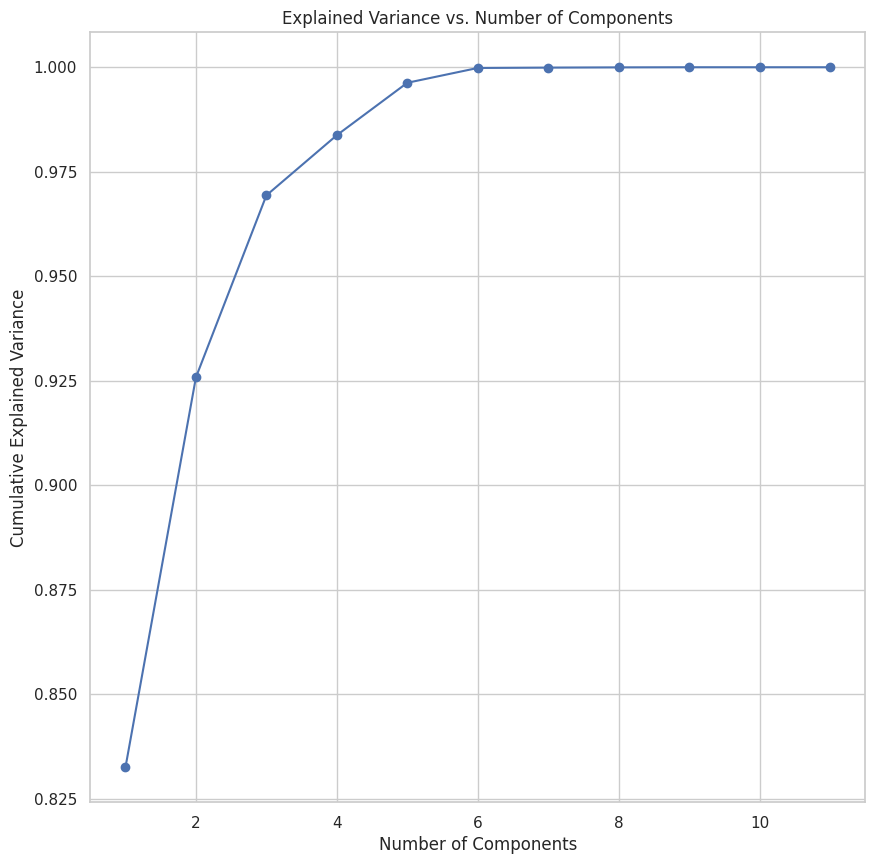

In [ ]:
# Plot the cumulative explained variance against the number of components
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
n_components = 11
pca = PCA(n_components=n_components)
X_pca_unseen = pca.fit_transform(scaled_df_unseen)

In [ ]:
# Access the principal components
principal_components = pca.components_

# Access the explained variance of each principal component
explained_variances = pca.explained_variance_ratio_

# Print the explained variance of each principal component
for i, explained_variance in enumerate(explained_variances):
    print(f"Principal Component {i+1}: {explained_variance:.4f}")



In [ ]:
X_pca_df_unseen = pd.DataFrame(X_pca_unseen)
# X_pca_df_unseen

In [ ]:
# Split x_pca into input sequences and target values
lookback = 10 #Using past 10 days'daily data of below columns'data to predict the 'Next_day' price
data_columns = [ 'Open', 'High', 'Low', 'Pct_change', 'MACD','Signal Line','Volatility' ,'Middle Band', 'Std Dev',
                'Upper Band', 'Lower Band']
target_columns = ['Next_day']

X_unseen = []
y_unseen = []
for i in range(len(X_pca_unseen) - lookback):
    X_unseen.append(X_pca_unseen[i:i+lookback])
    y_unseen.append(df_unseen['Next_day'].values[i+lookback])

# Convert to numpy arrays
X_unseen = np.array(X_unseen)
y_unseen = np.array(y_unseen)

In [ ]:
# Scale the input sequences (X)
scaler = MinMaxScaler()
#X = scaler.fit_transform(X_pca.reshape(X.shape[0], -1))
X_unseen = scaler.fit_transform(X_unseen.reshape(X_unseen.shape[0], -1))

# Scale the target variable (y)
y_scaler = MinMaxScaler()
y_unseen = y_scaler.fit_transform(y_unseen.reshape(-1, 1))

In [ ]:
X_unseen= X_unseen.reshape((X_unseen.shape[0], lookback, -1))

In [ ]:
#Predict the KOSPI value
y_pred_unseen = stacked_lstm_model.predict(X_unseen)

In [ ]:
# Calculate error metrics
real_rmse_unseen = np.sqrt(mean_squared_error(y_unseen, y_pred_unseen))
real_mse_unseen = mean_squared_error(y_unseen, y_pred_unseen)
real_mae_unseen = mean_absolute_error(y_unseen, y_pred_unseen)
real_mape_unseen = mean_absolute_percentage_error(y_unseen, y_pred_unseen)

# Print each value
print("RMSE (unseen data):", real_rmse_unseen)
print("MSE (unseen data):", real_mse_unseen)
print("MAE (unseen data):", real_mae_unseen)
print("MAPE (unseen data):", real_mape_unseen)

RMSE (unseen data): 0.046287016946107616
MSE (unseen data): 0.0021424879377692535
MAE (unseen data): 0.040964000167828835
MAPE (unseen data): 112158082794.83922


In [ ]:
# y_pred_unseen

In [ ]:
# y_unseen

In [ ]:
y_pred_unseen_original = y_scaler.inverse_transform(y_pred_unseen)
y_unseen_original = y_scaler.inverse_transform(y_unseen)

In [ ]:
# y_pred_unseen_original

In [ ]:
# y_unseen_original

In [ ]:
# Calculate error metrics
real_rmse_unseen = np.sqrt(mean_squared_error(y_unseen_original, y_pred_unseen_original))
real_mae_unseen = mean_absolute_error(y_unseen_original, y_pred_unseen_original)
real_mape_unseen = mean_absolute_percentage_error(y_unseen_original, y_pred_unseen_original)

# Print each value
print("RMSE of PCA-STACKED LSTM with KOSPI:", real_rmse_unseen)
print("MAE of PCA-STACKED LSTM with KOSPI:", real_mae_unseen)
print("MAPE of PCA-STACKED LSTM with KOSPI:", real_mape_unseen)

RMSE of PCA-STACKED LSTM with KOSPI: 85.51851177461823
MAE of PCA-STACKED LSTM with KOSPI: 75.68386701851378
MAPE of PCA-STACKED LSTM with KOSPI: 0.03592930832240391


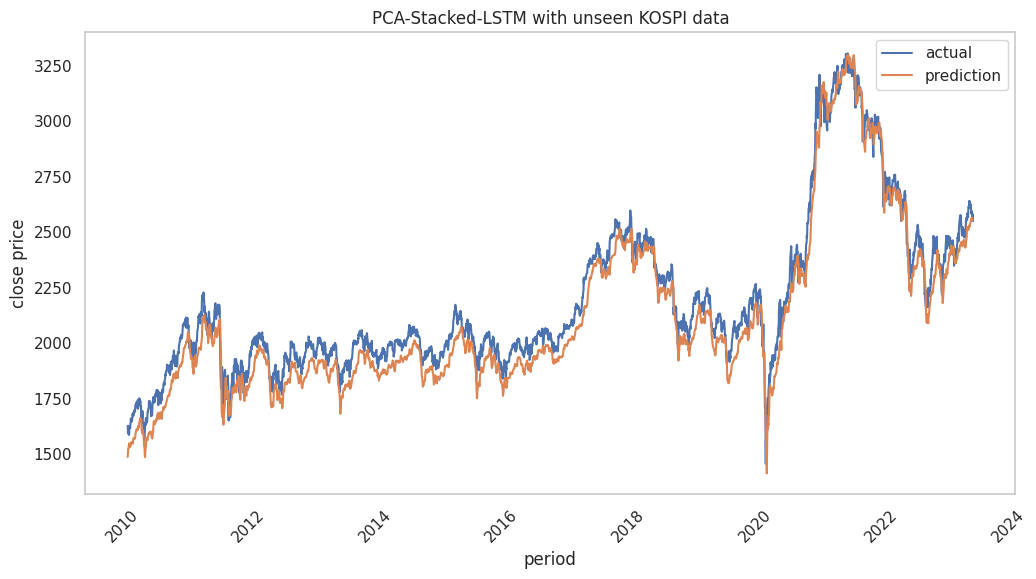

In [ ]:
#Real values of prediction
plt.figure(figsize=(12, 6))
plt.title('PCA-Stacked-LSTM with unseen KOSPI data')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(df_unseen.index[:len(y_unseen_original)],y_unseen_original, label='actual')
plt.plot(df_unseen.index[:len(y_pred_unseen_original)],y_pred_unseen_original, label='prediction')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='best')

plt.show()

### Voting Regressor for KOSPI Data

In [ ]:
y_unseen_df = df_unseen['Next_day']
y_unseen_df.shape

(3304,)

In [ ]:
y_unseen_array = np.array(y_unseen_df)
# y_unseen_reshaped = y_unseen_array.reshape(-1, 1)

In [ ]:
y_unseen_vr = y_scaler.fit_transform(y_unseen_array.reshape(-1, 1))

In [ ]:
# y_unseen_vr = y_scaler.fit_transform(y_unseen_array)

In [ ]:
y_pred_unseen_vr = vr.predict(X_pca_unseen)

In [ ]:
# Assuming y_pred_unseen_vr and y_unseen_vr are your arrays
y_pred_unseen_vr = y_pred_unseen_vr.reshape(-1, 1)
y_unseen_vr = y_unseen_vr.reshape(-1, 1)

# # Perform the inverse transformation
# y_pred_unseen_original = y_scaler.inverse_transform(y_pred_unseen_vr)
# y_unseen_original = y_scaler.inverse_transform(y_unseen_vr)


In [ ]:
real_rmse_unseen_vr = np.sqrt(mean_squared_error(y_unseen_vr, y_pred_unseen_vr))
real_mse_unseen_vr = mean_squared_error(y_unseen_vr, y_pred_unseen_vr)
real_mae_unseen_vr = mean_absolute_error(y_unseen_vr, y_pred_unseen_vr)
real_mape_unseen_vr = mean_absolute_percentage_error(y_unseen_vr, y_pred_unseen_vr)

# Print each value
print("RMSE (unseen data):", real_rmse_unseen_vr)
print("MSE (unseen data):", real_mse_unseen_vr)
print("MAE (unseen data):", real_mae_unseen_vr)
print("MAPE (unseen data):", real_mape_unseen_vr)

RMSE (unseen data): 0.1426502431851327
MSE (unseen data): 0.020349091880777496
MAE (unseen data): 0.09743114771543074
MAPE (unseen data): 365032930047.62964


In [ ]:
y_pred_unseen_vr = y_scaler.inverse_transform(y_pred_unseen_vr)
y_unseen_vr = y_scaler.inverse_transform(y_unseen_vr)

In [ ]:
real_rmse_unseen_vr = np.sqrt(mean_squared_error(y_unseen_vr, y_pred_unseen_vr))
real_mae_unseen_vr = mean_absolute_error(y_unseen_vr, y_pred_unseen_vr)
real_mape_unseen_vr = mean_absolute_percentage_error(y_unseen_vr, y_pred_unseen_vr)

# Print each value
print("RMSE of Voting Regressor with KOSPI:", real_rmse_unseen_vr)
print("MAE of Voting Regressor with KOSPI:", real_mae_unseen_vr)
print("MAPE of Voting Regressor with KOSPI:", real_mape_unseen_vr)

RMSE of Voting Regressor with KOSPI: 263.55630213967726
MAE of Voting Regressor with KOSPI: 180.0108603514801
MAPE of Voting Regressor with KOSPI: 0.07530838541207689


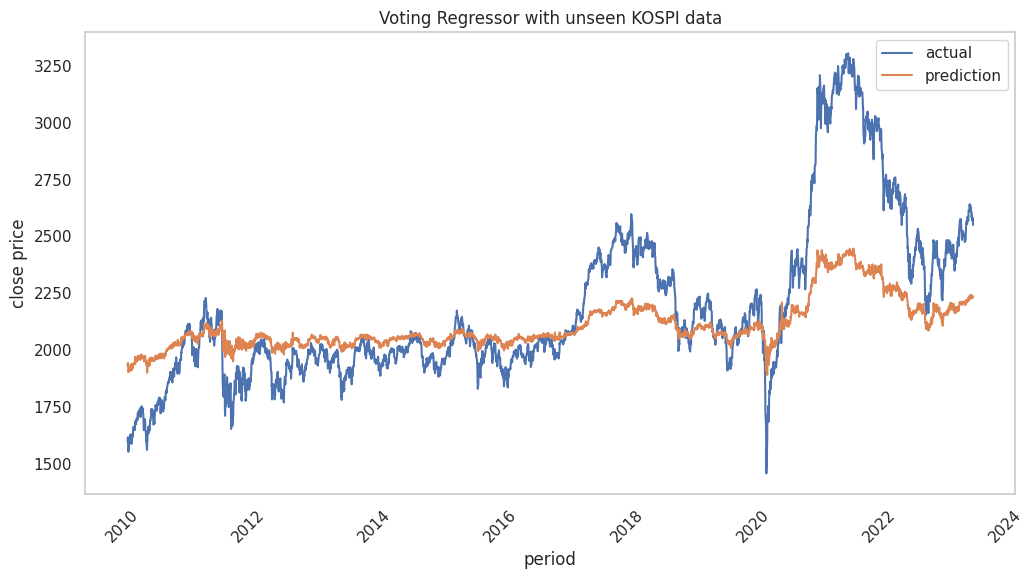

In [ ]:
#Real values of prediction
plt.figure(figsize=(12, 6))
plt.title('Voting Regressor with unseen KOSPI data')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(df_unseen.index,y_unseen_vr, label='actual')
plt.plot(df_unseen.index,y_pred_unseen_vr, label='prediction')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='best')

plt.show()

### Normal Stacked LSTM

In [ ]:
normal_stacked_pred_unseen = normal_stacked_lstm_model.predict(X_unseen)

In [ ]:
#stacked_pred = stacked_lstm_model.predict(X_p_test)
# plt.figure(figsize=(12, 6))
# plt.title('Normal-Stacked-LSTM with KOSPI, window_size=10')
# plt.ylabel('close price')
# plt.xlabel('period')
# plt.plot(y_unseen, label='actual')
# plt.plot(normal_stacked_pred_unseen, label='prediction')
# plt.grid()
# plt.legend(loc='best')

# plt.show()

In [ ]:
y_nstacked_pred_unseen = y_scaler.inverse_transform(normal_stacked_pred_unseen)
y_nstacked_test_unseen = y_scaler.inverse_transform(y_unseen)

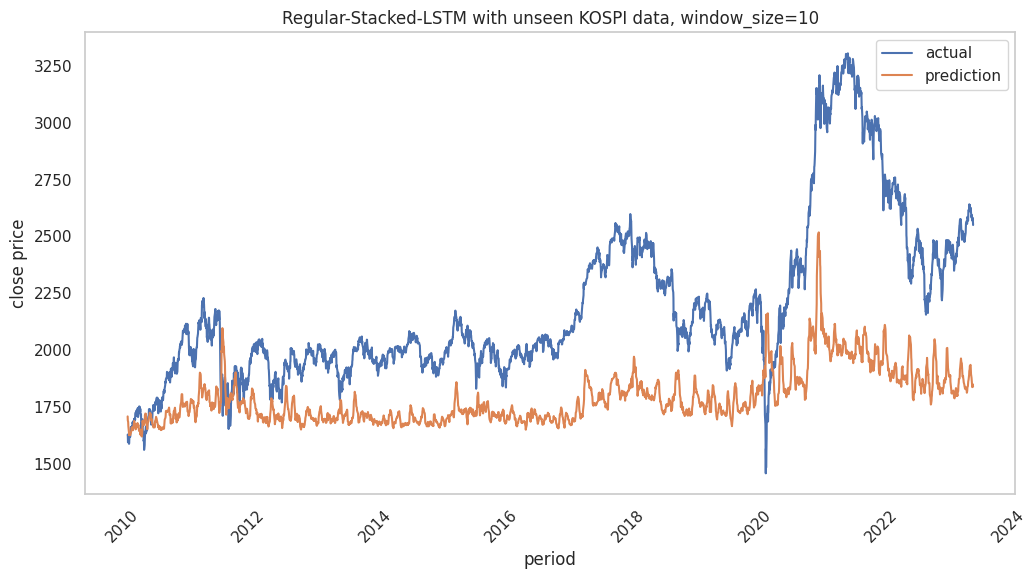

In [ ]:
#Real values of prediction
plt.figure(figsize=(12, 6))
plt.title('Regular-Stacked-LSTM with unseen KOSPI data, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(df_unseen.index[:len(y_nstacked_test_unseen)], y_nstacked_test_unseen, label='actual')
plt.plot(df_unseen.index[:len(y_nstacked_pred_unseen)], y_nstacked_pred_unseen, label='prediction')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='best')

plt.show()

In [ ]:
# Plot the training loss and validation loss over the epochs
# plt.figure(figsize=(5, 5))
# plt.plot(history_RS.history['loss'])
# plt.plot(history_RS.history['val_loss'])
# plt.title('Training Loss vs. Validation Loss of Regular-STACKED-LSTM')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
# plt.show()

In [ ]:
# Calculate error metrics
real_rmse_rstacked = np.sqrt(mean_squared_error(y_nstacked_test_unseen, y_nstacked_pred_unseen))
real_mae_rstacked = mean_absolute_error(y_nstacked_test_unseen, y_nstacked_pred_unseen)
real_mape_rstacked = mean_absolute_percentage_error(y_nstacked_test_unseen, y_nstacked_pred_unseen)

# Print each value
print("RMSE of Regular-Stacked-LSTM_KOSPI :", real_rmse_rstacked)
print("MAE of Regular-Stacked-LSTM_KOSPI :", real_mae_rstacked)
print("MAPE of Regular-Stacked-LSTM_KOSPI :", real_mape_rstacked)

RMSE of Regular-Stacked-LSTM_KOSPI : 484.7019948595376
MAE of Regular-Stacked-LSTM_KOSPI : 405.23677267735843
MAPE of Regular-Stacked-LSTM_KOSPI : 0.17305544603811568


### GRU for unseen data

In [ ]:
y_pred_unseen_rgu = GRU_model.predict(X_unseen)

In [ ]:
real_rmse_unseen_rgu = np.sqrt(mean_squared_error(y_unseen, y_pred_unseen_rgu))
real_mse_unseen_rgu = mean_squared_error(y_unseen, y_pred_unseen_rgu)
real_mae_unseen_rgu = mean_absolute_error(y_unseen, y_pred_unseen_rgu)
real_mape_unseen_rgu = mean_absolute_percentage_error(y_unseen, y_pred_unseen_rgu)

# Print each value
print("RMSE (unseen data):", real_rmse_unseen_rgu)
print("MSE (unseen data):", real_mse_unseen_rgu)
print("MAE (unseen data):", real_mae_unseen_rgu)
print("MAPE (unseen data):", real_mape_unseen_rgu)

RMSE (unseen data): 0.2579175165125683
MSE (unseen data): 0.06652144532401094
MAE (unseen data): 0.21811425754165423
MAPE (unseen data): 317395304289.3636


In [ ]:
y_pred_unseen_rgu = y_scaler.inverse_transform(y_pred_unseen_rgu)
y_unseen_rgu = y_scaler.inverse_transform(y_unseen)

In [ ]:
real_rmse_unseen_rgu = np.sqrt(mean_squared_error(y_unseen_rgu, y_pred_unseen_rgu))
real_mae_unseen_rgu = mean_absolute_error(y_unseen_rgu, y_pred_unseen_rgu)
real_mape_unseen_rgu = mean_absolute_percentage_error(y_unseen_rgu, y_pred_unseen_rgu)

# Print each value
print("RMSE of GRU with KOSPI:", real_rmse_unseen_rgu)
print("RMSE of GRU with KOSPI:", real_mae_unseen_rgu)
print("RMSE of GRU with KOSPI:", real_mape_unseen_rgu)

RMSE of GRU with KOSPI: 476.52066248042513
RMSE of GRU with KOSPI: 402.98135696531574
RMSE of GRU with KOSPI: 0.1727742276641043


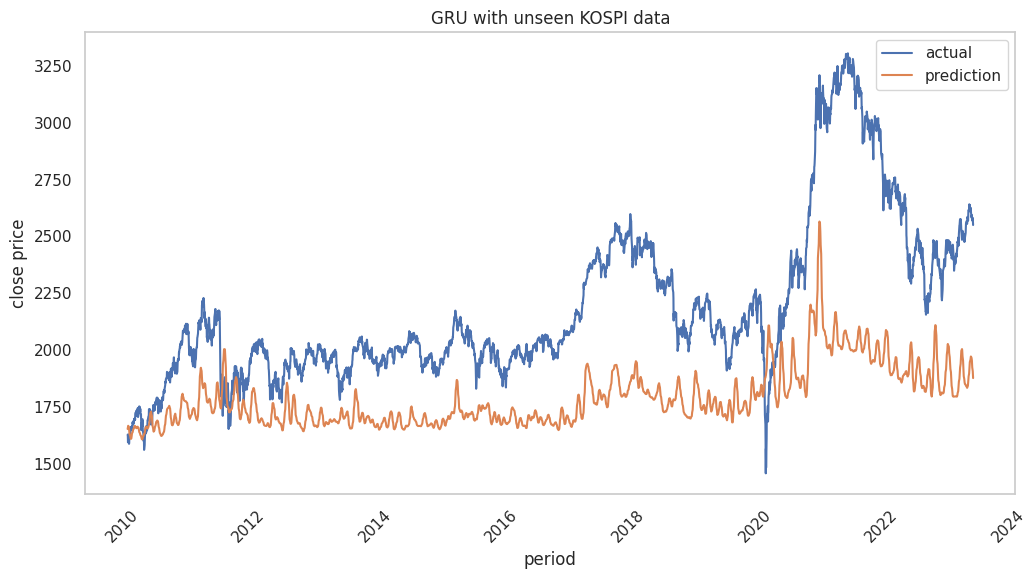

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('GRU with unseen KOSPI data')
plt.ylabel('close price')
plt.xlabel('period')
# plt.plot(y_unseen_rgu, label='actual')
# plt.plot(y_pred_unseen_rgu, label='prediction')
plt.plot(df_unseen.index[:len(y_unseen_rgu)], y_unseen_rgu, label='actual')
plt.plot(df_unseen.index[:len(y_pred_unseen_rgu)], y_pred_unseen_rgu, label='prediction')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='best')

plt.show()

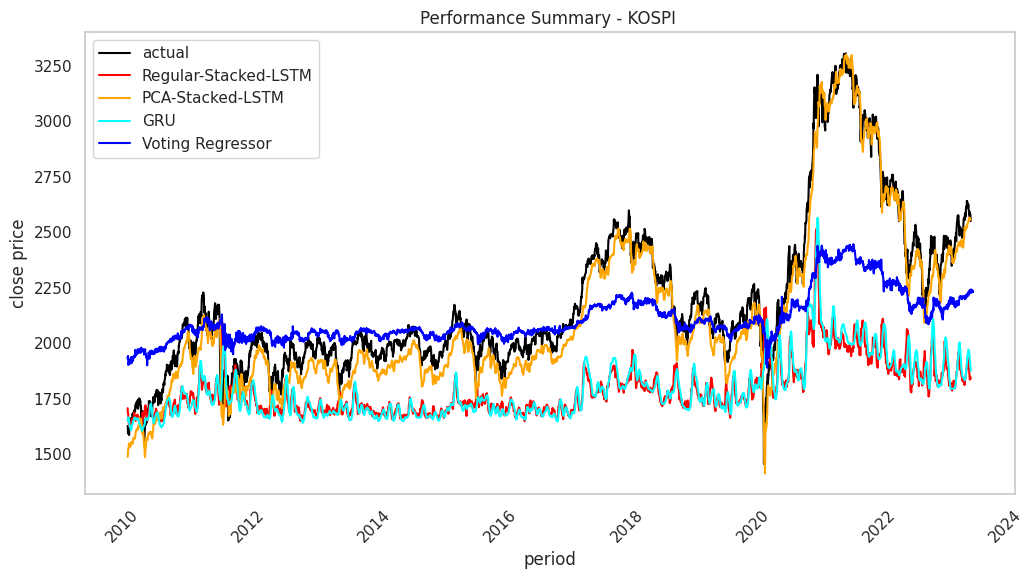

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Performance Summary - KOSPI ')
plt.ylabel('close price')
plt.xlabel('period')

plt.plot(df_unseen.index[:len(y_unseen_original)],y_unseen_original, label='actual', color='black')
plt.plot(df_unseen.index[:len(y_nstacked_pred_unseen)],y_nstacked_pred_unseen, label='Regular-Stacked-LSTM', color='red')
plt.plot(df_unseen.index[:len(y_pred_unseen_original)],y_pred_unseen_original, label='PCA-Stacked-LSTM', color='orange')
plt.plot(df_unseen.index[:len(y_pred_unseen_rgu)],y_pred_unseen_rgu, label='GRU', color='cyan')
plt.plot(df_unseen.index[:len(y_pred_unseen_vr)],y_pred_unseen_vr, label='Voting Regressor',color = 'blue')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='best')

plt.show()